In [1]:
!pip install tenseal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 13.6 MB/s eta 0:00:00


In [2]:
from google.colab import files
import json
import numpy as np
import tenseal as ts

# Upload the JSON file (This is still done on the server)
uploaded = files.upload()
filename = list(uploaded.keys())[0]

with open(filename, "r") as f:
    data = json.load(f)

Saving MMU (1).json to MMU (1).json


In [3]:
# DIAGNOSTIC: Check if your dataset features are normalized
sample_user = list(data.keys())[0]
sample_feature = data[sample_user]["features"][0]
sample_norm = np.linalg.norm(sample_feature)

print(f"\n=== DATASET DIAGNOSTIC ===")
print(f"Sample user: {sample_user}")
print(f"Sample feature norm: {sample_norm:.4f}")
print(f"Sample feature first 5 values: {sample_feature[:5]}")

if 0.9 < sample_norm < 1.1:
    print("✓ Dataset features appear to be NORMALIZED (norm ≈ 1.0)")
    print("  Your enrollment is correct - storing normalized vectors")
    print("  You need to normalize raw features during authentication")
elif sample_norm > 100:
    print("⚠️ Dataset features appear to be RAW (norm > 100)")
    print("  Your enrollment is INCORRECT - you should normalize before encryption!")
    print("  You need to modify your enrollment code to normalize features")
else:
    print(f"ℹ️ Dataset feature norm = {sample_norm:.4f} - unknown scale")


=== DATASET DIAGNOSTIC ===
Sample user: 1
Sample feature norm: 422.7161
Sample feature first 5 values: [61.632883687062844, -396.98667856760574, -57.09253633425689, -102.23017577972524, 59.844164158961874]
⚠️ Dataset features appear to be RAW (norm > 100)
  Your enrollment is INCORRECT - you should normalize before encryption!
  You need to modify your enrollment code to normalize features


In [4]:
# First, let's inspect what users we actually have in the original data
print("Users in original data:", list(data.keys())[:10])  # Show first 10 user IDs
print("Total users in data:", len(data))

# Check if user '1' exists in the original data
if '1' not in data:
    print("WARNING: User '1' does not exist in the original data!")
    # Let's use the first available user instead
    first_user_id = list(data.keys())[0]
    print(f"Using first available user: {first_user_id}")
else:
    first_user_id = '1'

Users in original data: ['1', '2', '3', '5', '6', '7', '8', '9', '10', '11']
Total users in data: 43


In [5]:
# Secure storage for private keys
user_private_keys = {}

# Database to store encrypted data
encrypted_database = {}

print("\n=== BUILDING ENCRYPTED DATABASE WITH NORMALIZATION ===")


def normalize_vector(v):
    import numpy as np
    v = np.array(v, dtype=np.float64)
    norm = np.linalg.norm(v)
    return (v / norm).tolist() if norm > 0 else v.tolist()

for user_id, user_data in data.items():
    print(f"Processing User {user_id}...")

    try:
        # Generate encryption context
        user_context = ts.context(
            ts.SCHEME_TYPE.CKKS,
            poly_modulus_degree=8192,
            coeff_mod_bit_sizes=[60, 40, 40, 60]
        )
        user_context.generate_galois_keys()
        user_context.global_scale = 2 ** 40

        # Store private key
        user_private_key = user_context.serialize(save_secret_key=True)
        user_private_keys[user_id] = user_private_key
        print(f"  ✓ Private key stored for user {user_id}")

        # Create public context
        user_public_context = user_context.copy()
        user_public_context.make_context_public()

        # ============================================
        # NORMALIZE EACH VECTOR BEFORE ENCRYPTION
        # ============================================
        user_encrypted_features = []
        for vec in user_data["features"]:
            # THIS IS THE KEY LINE - NORMALIZE FIRST!
            normalized_vec = normalize_vector(vec)

            # Encrypt the normalized vector
            enc_vec = ts.ckks_vector(user_public_context, normalized_vec)
            user_encrypted_features.append(enc_vec.serialize())

        # Store in database
        user_public_key = user_public_context.serialize()
        encrypted_database[user_id] = {
            'public_key': user_public_key,
            'encrypted_features': user_encrypted_features
        }

        print(f"  ✓ Added User {user_id} to database with {len(user_encrypted_features)} NORMALIZED features")

    except Exception as e:
        print(f"  ✗ Error with User {user_id}: {e}")
        continue

print(f"✓ Enrollment completed. Stored private keys for {len(user_private_keys)} users")


=== BUILDING ENCRYPTED DATABASE WITH NORMALIZATION ===
Processing User 1...
  ✓ Private key stored for user 1
  ✓ Added User 1 to database with 10 NORMALIZED features
Processing User 2...
  ✓ Private key stored for user 2
  ✓ Added User 2 to database with 10 NORMALIZED features
Processing User 3...
  ✓ Private key stored for user 3
  ✓ Added User 3 to database with 10 NORMALIZED features
Processing User 5...
  ✓ Private key stored for user 5
  ✓ Added User 5 to database with 10 NORMALIZED features
Processing User 6...
  ✓ Private key stored for user 6
  ✓ Added User 6 to database with 10 NORMALIZED features
Processing User 7...
  ✓ Private key stored for user 7
  ✓ Added User 7 to database with 10 NORMALIZED features
Processing User 8...
  ✓ Private key stored for user 8
  ✓ Added User 8 to database with 10 NORMALIZED features
Processing User 9...
  ✓ Private key stored for user 9
  ✓ Added User 9 to database with 10 NORMALIZED features
Processing User 10...
  ✓ Private key stored for

In [6]:
# Verify the database was built correctly
print("\n=== DATABASE VERIFICATION ===")
print("Users in encrypted database:", sorted(list(encrypted_database.keys()))[:10])
print(f"Total users in encrypted database: {len(encrypted_database)}")

# Check if specific users exist
for user_id in ['1', '2', '3', '44']:
    if user_id in encrypted_database:
        print(f"✓ User {user_id} found in database")
    else:
        print(f"✗ User {user_id} NOT found in database")


=== DATABASE VERIFICATION ===
Users in encrypted database: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18']
Total users in encrypted database: 43
✓ User 1 found in database
✓ User 2 found in database
✓ User 3 found in database
✓ User 44 found in database


In [21]:
def cosine_similarity_encrypted_public(v1, v2):
    """
    Compute cosine similarity using only homomorphic operations.
    Returns encrypted similarity score.
    """
    # Encrypted dot product
    dot_product = v1.dot(v2)

    # Encrypted squared norms
    norm_sq_v1 = v1.dot(v1)
    norm_sq_v2 = v2.dot(v2)

    # We can't decrypt the norms on server, so we return the encrypted components
    # Client will decrypt and compute final similarity
    return dot_product, norm_sq_v1, norm_sq_v2

In [22]:
# Cell 7: XAI Class Definition
class AuthenticationXAI:
    def __init__(self, threshold=0.70):
        self.threshold = threshold

    def explain_authentication(self, query_user_id, template_scores, feature_similarities_all, threshold=0.70):
        """
        Generate human-readable explanations for authentication decisions.
        """

        print(f"\n{'='*60}")
        print("EXPLAINABLE AI (XAI) - AUTHENTICATION DECISION ANALYSIS")
        print(f"{'='*60}")

        if not template_scores:
            print("ERROR: No template scores available for analysis")
            return

        best_template_idx = np.argmax(template_scores)
        best_score = template_scores[best_template_idx]

        is_authenticated = best_score >= threshold

        print(f"\n🔍 USER ANALYSIS: {query_user_id}")
        print(f"📊 BEST MATCH SCORE: {best_score:.4f}")
        print(f"🎯 THRESHOLD: {threshold}")
        print(f"📋 AUTHENTICATION: {'SUCCESSFUL ✅' if is_authenticated else 'FAILED ❌'}")
        print(f"📈 MARGIN: {best_score - threshold:+.4f}")

        # Overall score analysis
        print(f"\n📊 OVERALL SCORE ANALYSIS:")
        print(f"   • Templates analyzed: {len(template_scores)}")
        print(f"   • Templates above threshold: {sum(1 for s in template_scores if s >= threshold)}")
        print(f"   • Average template score: {np.mean(template_scores):.4f}")
        print(f"   • Score variance: {np.var(template_scores):.4f}")

        if len(template_scores) > 1:
            sorted_scores = sorted(template_scores, reverse=True)
            if sorted_scores[0] - sorted_scores[1] > 0.1:
                print(f"   • Best template significantly outperforms others")
            elif sorted_scores[0] - sorted_scores[1] < 0.05:
                print(f"   • Multiple templates show similar performance")

        # Feature-level analysis if available
        if feature_similarities_all and len(feature_similarities_all) > best_template_idx:
            feature_scores = feature_similarities_all[best_template_idx]
            if feature_scores:
                print(f"\n📈 FEATURE-LEVEL ANALYSIS (Best Template {best_template_idx + 1}):")

                for i, score in enumerate(feature_scores):
                    status = "✓" if score >= 0.7 else ("∼" if score >= 0.5 else "✗")
                    contribution = "HIGH" if score >= 0.8 else ("MEDIUM" if score >= 0.6 else "LOW")
                    print(f"   Feature {i+1}: {status} {score:.4f} ({contribution})")

                # Identify strongest and weakest features
                if len(feature_scores) > 1:
                    best_feature = np.argmax(feature_scores)
                    worst_feature = np.argmin(feature_scores)

                    if feature_scores[best_feature] >= 0.8:
                        print(f"   → Feature {best_feature + 1} was strongest contributor")
                    if feature_scores[worst_feature] < 0.5:
                        print(f"   → Feature {worst_feature + 1} was weakest contributor")

        # Decision explanation
        print(f"\n🎯 DECISION EXPLANATION:")
        if is_authenticated:
            print(f"   1. Template {best_template_idx + 1} achieved {best_score*100:.1f}% similarity")
            print(f"   2. Exceeded threshold by {(best_score - threshold)*100:.1f}%")

            if best_score >= 0.85:
                print(f"   3. Very strong biometric match detected")
            elif best_score >= 0.75:
                print(f"   3. Strong biometric match confirmed")
            else:
                print(f"   3. Adequate biometric match established")

            # Check consistency
            high_scoring_templates = sum(1 for s in template_scores if s >= threshold)
            if high_scoring_templates >= 3:
                print(f"   4. Multiple templates ({high_scoring_templates}) support authentication")

        else:
            print(f"   1. Best template only achieved {best_score*100:.1f}% similarity")
            print(f"   2. Fell short of threshold by {(threshold - best_score)*100:.1f}%")

            if best_score >= 0.65:
                print(f"   3. Close match but below security threshold")
                print(f"   4. Consider using more features or adjusting threshold slightly")
            elif best_score >= 0.5:
                print(f"   3. Moderate match - possible biometric variation")
                print(f"   4. Recommend re-capturing biometric data")
            else:
                print(f"   3. Poor match - likely incorrect user or data issue")
                print(f"   4. Consider re-enrollment")

        # Confidence assessment
        print(f"\n💡 CONFIDENCE ASSESSMENT:")
        if best_score >= 0.85:
            confidence = "VERY HIGH"
        elif best_score >= 0.75:
            confidence = "HIGH"
        elif best_score >= threshold:
            confidence = "MODERATE"
        elif best_score >= 0.6:
            confidence = "LOW"
        else:
            confidence = "VERY LOW"

        print(f"   • Decision Confidence: {confidence}")

        if is_authenticated:
            if confidence in ["VERY HIGH", "HIGH"]:
                print(f"   • Recommended Action: Grant full access")
            else:
                print(f"   • Recommended Action: Grant limited access + additional verification")
        else:
            if best_score >= 0.65:
                print(f"   • Recommended Action: Request re-authentication with more features")
            else:
                print(f"   • Recommended Action: Deny access + security alert")

        print(f"\n{'='*60}")
        print("XAI ANALYSIS COMPLETE")
        print(f"{'='*60}")

In [28]:
query_user_id = '30'
print(f"\n=== AUTHENTICATING USER {query_user_id} ===")

if query_user_id not in encrypted_database:
    print(f"ERROR: User {query_user_id} not found!")
    exit()

# ============================================
# FIX 1: ADD NORMALIZATION FUNCTION
# ============================================
def normalize_vector(v):
    """Normalize vector to unit length for cosine similarity"""
    import numpy as np
    v = np.array(v, dtype=np.float64)
    norm = np.linalg.norm(v)
    if norm > 0:
        return v / norm
    return v

# ============================================
# FIX 2: GET QUERY FEATURES AND NORMALIZE THEM
# ============================================

# Get query vectors from dataset (THESE ARE RAW, NEED NORMALIZATION!)
query_features = [
    [-152.31733667075224, -232.14842111207594, 126.51469500573947, 30.395121455151507, -0.8805459418830637],  # Feature at index 5
    [72.1822707397566, -353.67501966064447, -4.995963702210467, 0.34033182376788096, 54.17183534737734]   # Feature at index 6
]

print(f"✓ Selected {len(query_features)} query features: Feature 5 and Feature 6")

normalized_queries = []
for i, feat in enumerate(query_features):
    normalized = normalize_vector(feat)
    normalized_queries.append(normalized)

    # Print norms for debugging
    original_norm = np.linalg.norm(feat)
    normalized_norm = np.linalg.norm(normalized)
    print(f"  Feature {i+1}: original norm = {original_norm:.2f}, normalized norm = {normalized_norm:.2f}")

print("✓ All query features normalized to unit length")

# ============================================
# STEP 1: Retrieve the target user's public context
# ============================================
target_data = encrypted_database[query_user_id]
target_public_context = ts.context_from(target_data['public_key'])

# ============================================
# STEP 2: Encrypt NORMALIZED query vectors
# ============================================
enc_queries = []
for i, query_vec in enumerate(normalized_queries):
    # Convert numpy array to list for encryption
    enc_query = ts.ckks_vector(target_public_context, query_vec.tolist())
    enc_queries.append(enc_query)
print(f"✓ {len(enc_queries)} normalized query features encrypted with correct public key")

# ============================================
# STEP 3: Retrieve private context
# ============================================
try:
    if query_user_id not in user_private_keys:
        print(f"✗ No private key found for user {query_user_id}")
        print("  Make sure enrollment was run with proper key storage")
        exit()

    user_private_context = ts.context_from(user_private_keys[query_user_id])
    print("✓ Retrieved private context with secret key")

except Exception as e:
    print(f"✗ Failed to retrieve private context: {e}")
    exit()


=== AUTHENTICATING USER 30 ===
✓ Selected 2 query features: Feature 5 and Feature 6
  Feature 1: original norm = 306.63, normalized norm = 1.00
  Feature 2: original norm = 365.04, normalized norm = 1.00
✓ All query features normalized to unit length
✓ 2 normalized query features encrypted with correct public key
✓ Retrieved private context with secret key


In [31]:
print(f"\n=== SERVER-SIDE COMPARISON (Processing {len(enc_queries)} features) ===")

target_data = encrypted_database[query_user_id]
target_public_context = ts.context_from(target_data['public_key'])
target_enc_features = target_data['encrypted_features']

# Store all encrypted results for each feature and each template
encrypted_results_all = []  # This will be a 2D list: [template_index][feature_index]

for template_idx, enc_feat_serialized in enumerate(target_enc_features):
    try:
        # Deserialize encrypted template vector with public context
        enc_feat = ts.ckks_vector_from(target_public_context, enc_feat_serialized)

        template_results = []

        # Compare each query feature with this template
        for feature_idx, enc_query in enumerate(enc_queries):
            # Compute encrypted similarity (dot product, norm squared) for each feature
            dot_product, norm_sq_v1, norm_sq_v2 = cosine_similarity_encrypted_public(enc_query, enc_feat)

            # Store encrypted results for this feature
            template_results.append({
                'dot_product': dot_product.serialize(),
                'norm_sq_v1': norm_sq_v1.serialize(),
                'norm_sq_v2': norm_sq_v2.serialize()
            })

        # Add all feature results for this template
        encrypted_results_all.append(template_results)
        print(f"  ✓ Template {template_idx + 1}: All {len(enc_queries)} feature comparisons completed")

    except Exception as e:
        print(f"  ✗ Template {template_idx + 1}: Error during comparison: {e}")
        encrypted_results_all.append([])  # Empty list for failed template



decrypted_average_scores = []
successful_decryptions = 0

for template_idx, template_results in enumerate(encrypted_results_all):
    if not template_results:  # Skip failed comparisons
        print(f"  ✗ Template {template_idx + 1}: Skipping - no comparison results")
        decrypted_average_scores.append(0.0)
        continue

    try:
        feature_similarities = []

        # Decrypt and compute similarity for each feature
        for feature_idx, result in enumerate(template_results):
            # Deserialize encrypted vectors with private context (secret key)
            dot_product_enc = ts.ckks_vector_from(user_private_context, result['dot_product'])
            norm_sq_v1_enc = ts.ckks_vector_from(user_private_context, result['norm_sq_v1'])
            norm_sq_v2_enc = ts.ckks_vector_from(user_private_context, result['norm_sq_v2'])

            # Decrypt the components
            dot_product = dot_product_enc.decrypt()[0]
            norm_sq_v1_val = norm_sq_v1_enc.decrypt()[0]
            norm_sq_v2_val = norm_sq_v2_enc.decrypt()[0]

            # Calculate cosine similarity safely
            norm_sq_v1_val = max(0, norm_sq_v1_val)
            norm_sq_v2_val = max(0, norm_sq_v2_val)
            norm_v1 = np.sqrt(norm_sq_v1_val) if norm_sq_v1_val > 0 else 0
            norm_v2 = np.sqrt(norm_sq_v2_val) if norm_sq_v2_val > 0 else 0

            if norm_v1 == 0 or norm_v2 == 0:
                similarity = 0.0
            else:
                similarity = dot_product / (norm_v1 * norm_v2)

            similarity = max(-1.0, min(1.0, similarity))
            feature_similarities.append(similarity)

        # Calculate average similarity across all features for this template
        average_similarity = sum(feature_similarities) / len(feature_similarities)
        decrypted_average_scores.append(average_similarity)
        successful_decryptions += 1

    except Exception as e:
        print(f"  ✗ Template {template_idx + 1}: Error decrypting: {e}")
        decrypted_average_scores.append(0.0)


=== SERVER-SIDE COMPARISON (Processing 2 features) ===
  ✓ Template 1: All 2 feature comparisons completed
  ✓ Template 2: All 2 feature comparisons completed
  ✓ Template 3: All 2 feature comparisons completed
  ✓ Template 4: All 2 feature comparisons completed
  ✓ Template 5: All 2 feature comparisons completed
  ✓ Template 6: All 2 feature comparisons completed
  ✓ Template 7: All 2 feature comparisons completed
  ✓ Template 8: All 2 feature comparisons completed
  ✓ Template 9: All 2 feature comparisons completed
  ✓ Template 10: All 2 feature comparisons completed


In [32]:
# Cell 10: Client-side Decryption with XAI Data Collection
print(f"\n=== CLIENT-SIDE DECRYPTION AND AVERAGE COMPUTATION ===")

decrypted_average_scores = []
feature_similarities_all = []  # NEW: Store feature-level scores for XAI
successful_decryptions = 0

for template_idx, template_results in enumerate(encrypted_results_all):
    if not template_results:  # Skip failed comparisons
        print(f"  ✗ Template {template_idx + 1}: Skipping - no comparison results")
        decrypted_average_scores.append(0.0)
        feature_similarities_all.append([])  # Empty list for this template
        continue

    try:
        feature_similarities = []

        # Decrypt and compute similarity for each feature
        for feature_idx, result in enumerate(template_results):
            # Deserialize encrypted vectors with private context
            dot_product_enc = ts.ckks_vector_from(user_private_context, result['dot_product'])
            norm_sq_v1_enc = ts.ckks_vector_from(user_private_context, result['norm_sq_v1'])
            norm_sq_v2_enc = ts.ckks_vector_from(user_private_context, result['norm_sq_v2'])

            # Decrypt the components
            dot_product = dot_product_enc.decrypt()[0]
            norm_sq_v1_val = norm_sq_v1_enc.decrypt()[0]
            norm_sq_v2_val = norm_sq_v2_enc.decrypt()[0]

            # Calculate cosine similarity safely
            norm_sq_v1_val = max(0, norm_sq_v1_val)
            norm_sq_v2_val = max(0, norm_sq_v2_val)
            norm_v1 = np.sqrt(norm_sq_v1_val) if norm_sq_v1_val > 0 else 0
            norm_v2 = np.sqrt(norm_sq_v2_val) if norm_sq_v2_val > 0 else 0

            if norm_v1 == 0 or norm_v2 == 0:
                similarity = 0.0
            else:
                similarity = dot_product / (norm_v1 * norm_v2)

            similarity = max(-1.0, min(1.0, similarity))
            feature_similarities.append(similarity)

        # Store feature-level scores for XAI
        feature_similarities_all.append(feature_similarities)

        # Calculate average similarity
        average_similarity = sum(feature_similarities) / len(feature_similarities)
        decrypted_average_scores.append(average_similarity)
        successful_decryptions += 1

        # Display results
        print(f"  ✓ Template {template_idx + 1}:")
        for i, sim in enumerate(feature_similarities):
            print(f"      Feature {i + 1} similarity: {sim:.4f}")
        print(f"      Average similarity: {average_similarity:.4f}")

    except Exception as e:
        print(f"  ✗ Template {template_idx + 1}: Error decrypting: {e}")
        decrypted_average_scores.append(0.0)
        feature_similarities_all.append([])


=== CLIENT-SIDE DECRYPTION AND AVERAGE COMPUTATION ===
  ✓ Template 1:
      Feature 1 similarity: 0.8056
      Feature 2 similarity: 0.2360
      Average similarity: 0.5208
  ✓ Template 2:
      Feature 1 similarity: 0.8328
      Feature 2 similarity: 0.3247
      Average similarity: 0.5787
  ✓ Template 3:
      Feature 1 similarity: 0.3139
      Feature 2 similarity: 0.9076
      Average similarity: 0.6108
  ✓ Template 4:
      Feature 1 similarity: 0.9046
      Feature 2 similarity: 0.3621
      Average similarity: 0.6333
  ✓ Template 5:
      Feature 1 similarity: 0.9340
      Feature 2 similarity: 0.5821
      Average similarity: 0.7581
  ✓ Template 6:
      Feature 1 similarity: 0.7999
      Feature 2 similarity: 0.1171
      Average similarity: 0.4585
  ✓ Template 7:
      Feature 1 similarity: 0.8836
      Feature 2 similarity: 0.3199
      Average similarity: 0.6017
  ✓ Template 8:
      Feature 1 similarity: 0.9022
      Feature 2 similarity: 0.3999
      Average similarity:

In [33]:
print(f"\n=== FINAL AUTHENTICATION RESULTS (Average of {len(query_features)} Features) ===")
print(f"Successful decryptions: {successful_decryptions}/{len(target_enc_features)}")

if successful_decryptions > 0:
    # Create list with (user_id, average_similarity) tuples
    client_side_scores = [(query_user_id, score) for score in decrypted_average_scores]
    client_side_scores = sorted(client_side_scores, key=lambda x: x[1], reverse=True)

    print(f"\nTop Matches (Average of {len(query_features)} Features):")
    for i, (uid, avg_sim) in enumerate(client_side_scores[:5]):
        print(f"  {i+1}. User {uid} [Template {i+1}] -> Average Similarity: {avg_sim:.4f}")

    threshold = 0.75
    best_match = client_side_scores[0]

    print(f"\nAuthentication Threshold: {threshold}")
    print(f"Best Match Average Similarity: {best_match[1]:.4f}")

    if best_match[1] >= threshold:
        print(f"✓ Authenticated as User {best_match[0]} with average similarity {best_match[1]:.4f} ✅")
    else:
        print(f"✗ Authentication failed. Best match is User {best_match[0]} with average similarity {best_match[1]:.4f} ❌")

    # Additional diagnostic information
    print(f"\n=== DIAGNOSTIC INFORMATION ===")
    print(f"Number of query features used: {len(query_features)}")
    print(f"Number of templates processed: {len(target_enc_features)}")

    # Show individual feature performances
    if decrypted_average_scores:
        print(f"\nIndividual Template Results:")
        for i, avg_score in enumerate(decrypted_average_scores):
            if avg_score > 0:  # Only show successful ones
                print(f"  Template {i+1}: Average Score = {avg_score:.4f}")

else:
    print("✗ No successful decryptions - authentication failed")


=== FINAL AUTHENTICATION RESULTS (Average of 2 Features) ===
Successful decryptions: 10/10

Top Matches (Average of 2 Features):
  1. User 30 [Template 1] -> Average Similarity: 0.8242
  2. User 30 [Template 2] -> Average Similarity: 0.7581
  3. User 30 [Template 3] -> Average Similarity: 0.6510
  4. User 30 [Template 4] -> Average Similarity: 0.6333
  5. User 30 [Template 5] -> Average Similarity: 0.6108

Authentication Threshold: 0.75
Best Match Average Similarity: 0.8242
✓ Authenticated as User 30 with average similarity 0.8242 ✅

=== DIAGNOSTIC INFORMATION ===
Number of query features used: 2
Number of templates processed: 10

Individual Template Results:
  Template 1: Average Score = 0.5208
  Template 2: Average Score = 0.5787
  Template 3: Average Score = 0.6108
  Template 4: Average Score = 0.6333
  Template 5: Average Score = 0.7581
  Template 6: Average Score = 0.4585
  Template 7: Average Score = 0.6017
  Template 8: Average Score = 0.6510
  Template 9: Average Score = 0.489

In [34]:
# Cell 12: XAI Analysis
print(f"\n{'='*60}")
print("XAI DECISION EXPLANATION")
print(f"{'='*60}")

# Simple XAI explanation
best_score = max(decrypted_average_scores) if decrypted_average_scores else 0
threshold = 0.70

print(f"\n🔍 QUICK ANALYSIS:")
print(f"   User: {query_user_id}")
print(f"   Best Score: {best_score:.4f}")
print(f"   Threshold: {threshold}")
print(f"   Result: {'AUTHENTICATED ✅' if best_score >= threshold else 'REJECTED ❌'}")

if best_score >= threshold:
    print(f"\n✅ REASONS FOR AUTHENTICATION:")
    print(f"   1. Strong match: {best_score*100:.1f}% similarity")
    print(f"   2. Exceeds threshold by {(best_score - threshold)*100:.1f}%")

    successful_templates = sum(1 for s in decrypted_average_scores if s >= threshold)
    print(f"   3. {successful_templates}/{len(decrypted_average_scores)} templates confirm identity")

    if successful_templates >= 3:
        print(f"   4. High consistency across multiple templates")

    # Check feature performance
    if feature_similarities_all:
        best_template_idx = np.argmax(decrypted_average_scores)
        if best_template_idx < len(feature_similarities_all):
            best_features = feature_similarities_all[best_template_idx]
            strong_features = sum(1 for f in best_features if f >= 0.7)
            if strong_features > 0:
                print(f"   5. {strong_features}/{len(best_features)} features showed strong matches")

    print(f"\n💡 CONFIDENCE: {'HIGH' if best_score > 0.8 else 'MODERATE'}")

else:
    print(f"\n❌ REASONS FOR REJECTION:")
    print(f"   1. Insufficient match: {best_score*100:.1f}% similarity")
    print(f"   2. Below threshold by {(threshold - best_score)*100:.1f}%")

    close_templates = [s for s in decrypted_average_scores if 0.65 <= s < threshold]
    if close_templates:
        print(f"   3. {len(close_templates)} templates were close to threshold")
        print(f"   4. Consider: Adjusting threshold or adding more features")
    else:
        print(f"   3. Poor match across all templates")
        print(f"   4. Consider: Re-enrollment or verifying user identity")

    print(f"\n⚠️  RECOMMENDATION: {'Re-authenticate with more features' if best_score >= 0.6 else 'Security review recommended'}")

# Run detailed XAI analysis
print(f"\n{'='*60}")
print("DETAILED XAI ANALYSIS")
print(f"{'='*60}")

xai_analyzer = AuthenticationXAI(threshold=0.70)
xai_analyzer.explain_authentication(
    query_user_id=query_user_id,
    template_scores=decrypted_average_scores,
    feature_similarities_all=feature_similarities_all,
    threshold=0.70
)


XAI DECISION EXPLANATION

🔍 QUICK ANALYSIS:
   User: 30
   Best Score: 0.8242
   Threshold: 0.7
   Result: AUTHENTICATED ✅

✅ REASONS FOR AUTHENTICATION:
   1. Strong match: 82.4% similarity
   2. Exceeds threshold by 12.4%
   3. 2/10 templates confirm identity
   5. 1/2 features showed strong matches

💡 CONFIDENCE: HIGH

DETAILED XAI ANALYSIS

EXPLAINABLE AI (XAI) - AUTHENTICATION DECISION ANALYSIS

🔍 USER ANALYSIS: 30
📊 BEST MATCH SCORE: 0.8242
🎯 THRESHOLD: 0.7
📋 AUTHENTICATION: SUCCESSFUL ✅
📈 MARGIN: +0.1242

📊 OVERALL SCORE ANALYSIS:
   • Templates analyzed: 10
   • Templates above threshold: 2
   • Average template score: 0.6127
   • Score variance: 0.0116

📈 FEATURE-LEVEL ANALYSIS (Best Template 10):
   Feature 1: ✓ 0.9793 (HIGH)
   Feature 2: ∼ 0.6692 (MEDIUM)
   → Feature 1 was strongest contributor

🎯 DECISION EXPLANATION:
   1. Template 10 achieved 82.4% similarity
   2. Exceeded threshold by 12.4%
   3. Strong biometric match confirmed

💡 CONFIDENCE ASSESSMENT:
   • Decisio

In [11]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve
import seaborn as sns

def evaluate_authentication_performance(num_users=100, threshold_range=None, num_features_list=None):
    """
    Comprehensive performance evaluation of the authentication system

    Parameters:
    - num_users: Number of users to evaluate
    - threshold_range: Range of thresholds to test (default: 0.5 to 1.0)
    - num_features_list: List of different numbers of features to test
    """

    if threshold_range is None:
        threshold_range = np.arange(0.5, 1.0, 0.05)

    if num_features_list is None:
        num_features_list = [1, 2, 3, 4, 5]

    print("=" * 70)
    print("AUTHENTICATION SYSTEM PERFORMANCE EVALUATION")
    print("=" * 70)

    # Store all results
    all_results = {
        'genuine_scores': [],
        'impostor_scores': [],
        'metrics': {},
        'timing': {}
    }

    # Test different numbers of features
    for num_features in num_features_list:
        print(f"\n{'='*60}")
        print(f"EVALUATING WITH {num_features} FEATURE(S)")
        print(f"{'='*60}")

        genuine_scores = []
        impostor_scores = []
        processing_times = []

        # Track genuine and impostor attempts
        for query_user_id in list(data.keys())[:num_users]:
            if query_user_id not in encrypted_database:
                continue

            # Get query vectors (take first num_features available)
            query_features = []
            for i in range(min(num_features, len(data[query_user_id]["features"]))):
                query_features.append(data[query_user_id]["features"][i])

            if not query_features:
                continue

            # ========== GENUINE ATTEMPTS (Same User) ==========
            start_time = time.time()

            try:
                # Get target user's public context
                target_data = encrypted_database[query_user_id]
                target_public_context = ts.context_from(target_data['public_key'])

                # Encrypt query vectors
                enc_queries = []
                for query_vec in query_features:
                    enc_query = ts.ckks_vector(target_public_context, query_vec)
                    enc_queries.append(enc_query)

                # Get private context
                if query_user_id not in user_private_keys:
                    continue

                user_private_context = ts.context_from(user_private_keys[query_user_id])

                # Get encrypted features
                target_enc_features = target_data['encrypted_features']

                # Compare with each template
                best_score = 0
                for template_idx, enc_feat_serialized in enumerate(target_enc_features[:3]):  # Test with first 3 templates
                    try:
                        enc_feat = ts.ckks_vector_from(target_public_context, enc_feat_serialized)

                        feature_scores = []
                        for enc_query in enc_queries:
                            # Compute similarity
                            dot_product, norm_sq_v1, norm_sq_v2 = cosine_similarity_encrypted_public(enc_query, enc_feat)

                            # Decrypt and compute similarity
                            dot_product_enc = ts.ckks_vector_from(user_private_context, dot_product.serialize())
                            norm_sq_v1_enc = ts.ckks_vector_from(user_private_context, norm_sq_v1.serialize())
                            norm_sq_v2_enc = ts.ckks_vector_from(user_private_context, norm_sq_v2.serialize())

                            dp = dot_product_enc.decrypt()[0]
                            n1 = max(0, norm_sq_v1_enc.decrypt()[0])
                            n2 = max(0, norm_sq_v2_enc.decrypt()[0])

                            norm_v1 = np.sqrt(n1) if n1 > 0 else 0
                            norm_v2 = np.sqrt(n2) if n2 > 0 else 0

                            if norm_v1 == 0 or norm_v2 == 0:
                                similarity = 0.0
                            else:
                                similarity = dp / (norm_v1 * norm_v2)

                            similarity = max(-1.0, min(1.0, similarity))
                            feature_scores.append(similarity)

                        # Average score for this template
                        avg_score = sum(feature_scores) / len(feature_scores)
                        best_score = max(best_score, avg_score)

                    except Exception as e:
                        continue

                genuine_scores.append(best_score)

                # ========== IMPOSTOR ATTEMPTS (Different Users) ==========
                # Test against 5 different users
                impostor_targets = [uid for uid in list(encrypted_database.keys())[:20]
                                  if uid != query_user_id][:5]

                for imposter_id in impostor_targets:
                    try:
                        imposter_data = encrypted_database[imposter_id]
                        imposter_public_context = ts.context_from(imposter_data['public_key'])

                        # Re-encrypt queries with imposter's public key
                        enc_queries_imposter = []
                        for query_vec in query_features:
                            enc_query = ts.ckks_vector(imposter_public_context, query_vec)
                            enc_queries_imposter.append(enc_query)

                        imposter_enc_features = imposter_data['encrypted_features']

                        imposter_score = 0
                        for enc_feat_serialized in imposter_enc_features[:2]:  # Test 2 templates
                            try:
                                enc_feat = ts.ckks_vector_from(imposter_public_context, enc_feat_serialized)

                                feature_scores = []
                                for enc_query in enc_queries_imposter:
                                    dot_product, norm_sq_v1, norm_sq_v2 = cosine_similarity_encrypted_public(enc_query, enc_feat)

                                    # Use query user's private context to decrypt
                                    dot_product_enc = ts.ckks_vector_from(user_private_context, dot_product.serialize())
                                    norm_sq_v1_enc = ts.ckks_vector_from(user_private_context, norm_sq_v1.serialize())
                                    norm_sq_v2_enc = ts.ckks_vector_from(user_private_context, norm_sq_v2.serialize())

                                    dp = dot_product_enc.decrypt()[0]
                                    n1 = max(0, norm_sq_v1_enc.decrypt()[0])
                                    n2 = max(0, norm_sq_v2_enc.decrypt()[0])

                                    norm_v1 = np.sqrt(n1) if n1 > 0 else 0
                                    norm_v2 = np.sqrt(n2) if n2 > 0 else 0

                                    if norm_v1 == 0 or norm_v2 == 0:
                                        similarity = 0.0
                                    else:
                                        similarity = dp / (norm_v1 * norm_v2)

                                    similarity = max(-1.0, min(1.0, similarity))
                                    feature_scores.append(similarity)

                                avg_score = sum(feature_scores) / len(feature_scores)
                                imposter_score = max(imposter_score, avg_score)

                            except Exception as e:
                                continue

                        impostor_scores.append(imposter_score)

                    except Exception as e:
                        continue

                processing_time = time.time() - start_time
                processing_times.append(processing_time)

            except Exception as e:
                print(f"Error processing user {query_user_id}: {e}")
                continue

        # Calculate metrics
        if genuine_scores and impostor_scores:
            # Store scores
            all_results[f'genuine_{num_features}feat'] = genuine_scores
            all_results[f'impostor_{num_features}feat'] = impostor_scores
            all_results['timing'][f'avg_time_{num_features}feat'] = np.mean(processing_times)

            # Calculate metrics for different thresholds
            metrics = calculate_performance_metrics(genuine_scores, impostor_scores, threshold_range)
            all_results['metrics'][num_features] = metrics

            # Print summary
            print_summary(num_features, genuine_scores, impostor_scores, metrics, processing_times)

    # Generate comprehensive visualizations
    generate_visualizations(all_results, threshold_range, num_features_list)

    return all_results

def calculate_performance_metrics(genuine_scores, impostor_scores, threshold_range):
    """Calculate various performance metrics"""
    metrics = {
        'thresholds': threshold_range,
        'far': [],  # False Acceptance Rate
        'frr': [],  # False Rejection Rate
        'gar': [],  # Genuine Acceptance Rate
        'eer': None,  # Equal Error Rate
        'auc': None,  # Area Under ROC Curve
        'best_threshold': None
    }

    # Calculate FAR and FRR for each threshold
    for threshold in threshold_range:
        # False Acceptance: Impostor accepted
        far = sum(score >= threshold for score in impostor_scores) / len(impostor_scores) if impostor_scores else 0

        # False Rejection: Genuine rejected
        frr = sum(score < threshold for score in genuine_scores) / len(genuine_scores) if genuine_scores else 0

        metrics['far'].append(far)
        metrics['frr'].append(frr)
        metrics['gar'].append(1 - frr)  # Genuine Acceptance Rate

    # Find Equal Error Rate (EER)
    min_diff_idx = np.argmin(np.abs(np.array(metrics['far']) - np.array(metrics['frr'])))
    metrics['eer'] = (metrics['far'][min_diff_idx] + metrics['frr'][min_diff_idx]) / 2
    metrics['best_threshold'] = threshold_range[min_diff_idx]

    # Calculate AUC for ROC curve
    y_true = [1] * len(genuine_scores) + [0] * len(impostor_scores)
    y_scores = list(genuine_scores) + list(impostor_scores)

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    metrics['auc'] = auc(fpr, tpr)

    # Calculate precision-recall metrics at best threshold
    tn = sum(score < metrics['best_threshold'] for score in impostor_scores)
    fp = sum(score >= metrics['best_threshold'] for score in impostor_scores)
    fn = sum(score < metrics['best_threshold'] for score in genuine_scores)
    tp = sum(score >= metrics['best_threshold'] for score in genuine_scores)

    metrics['confusion_matrix'] = [[tn, fp], [fn, tp]]
    metrics['accuracy'] = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    metrics['precision'] = tp / (tp + fp) if (tp + fp) > 0 else 0
    metrics['recall'] = tp / (tp + fn) if (tp + fn) > 0 else 0
    metrics['f1_score'] = 2 * (metrics['precision'] * metrics['recall']) / (metrics['precision'] + metrics['recall']) if (metrics['precision'] + metrics['recall']) > 0 else 0

    return metrics

def print_summary(num_features, genuine_scores, impostor_scores, metrics, processing_times):
    """Print summary of performance for given number of features"""
    print(f"\nSUMMARY FOR {num_features} FEATURE(S):")
    print("-" * 40)

    print(f"Number of genuine attempts: {len(genuine_scores)}")
    print(f"Number of impostor attempts: {len(impostor_scores)}")
    print(f"Average processing time: {np.mean(processing_times):.3f} seconds")
    print(f"Min processing time: {np.min(processing_times):.3f} seconds")
    print(f"Max processing time: {np.max(processing_times):.3f} seconds")

    print(f"\nScore Statistics:")
    print(f"  Genuine scores - Mean: {np.mean(genuine_scores):.4f}, Std: {np.std(genuine_scores):.4f}")
    print(f"  Impostor scores - Mean: {np.mean(impostor_scores):.4f}, Std: {np.std(impostor_scores):.4f}")

    print(f"\nPerformance Metrics:")
    print(f"  Best Threshold: {metrics['best_threshold']:.4f}")
    print(f"  Equal Error Rate (EER): {metrics['eer']:.4f}")
    print(f"  AUC: {metrics['auc']:.4f}")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  F1-Score: {metrics['f1_score']:.4f}")

    # Print confusion matrix at best threshold
    cm = metrics['confusion_matrix']
    print(f"\nConfusion Matrix at threshold {metrics['best_threshold']:.4f}:")
    print(f"          Predicted Negative  Predicted Positive")
    print(f"Actual Negative      {cm[0][0]:4d}             {cm[0][1]:4d}")
    print(f"Actual Positive      {cm[1][0]:4d}             {cm[1][1]:4d}")

def generate_visualizations(all_results, threshold_range, num_features_list):
    """Generate comprehensive visualizations"""

    plt.figure(figsize=(20, 12))

    # 1. Score Distribution
    plt.subplot(2, 3, 1)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(num_features_list)))

    for idx, num_features in enumerate(num_features_list):
        genuine_key = f'genuine_{num_features}feat'
        impostor_key = f'impostor_{num_features}feat'

        if genuine_key in all_results and impostor_key in all_results:
            plt.hist(all_results[genuine_key], bins=30, alpha=0.5,
                    label=f'Genuine ({num_features} feat)', color=colors[idx], density=True)
            plt.hist(all_results[impostor_key], bins=30, alpha=0.5,
                    label=f'Impostor ({num_features} feat)', color=colors[idx],
                    linestyle='dashed', density=True)

    plt.xlabel('Similarity Score')
    plt.ylabel('Density')
    plt.title('Score Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. ROC Curves
    plt.subplot(2, 3, 2)
    for num_features in num_features_list:
        if num_features in all_results['metrics']:
            metrics = all_results['metrics'][num_features]
            y_true = [1] * len(all_results[f'genuine_{num_features}feat']) + \
                    [0] * len(all_results[f'impostor_{num_features}feat'])
            y_scores = all_results[f'genuine_{num_features}feat'] + \
                      all_results[f'impostor_{num_features}feat']
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            roc_auc = metrics['auc']
            plt.plot(fpr, tpr, label=f'{num_features} feature(s) (AUC = {roc_auc:.3f})', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

    # 3. FAR vs FRR (DET Curve)
    plt.subplot(2, 3, 3)
    for num_features in num_features_list:
        if num_features in all_results['metrics']:
            metrics = all_results['metrics'][num_features]
            plt.plot(threshold_range, metrics['far'], label=f'{num_features} feat FAR', linewidth=2)
            plt.plot(threshold_range, metrics['frr'], label=f'{num_features} feat FRR',
                    linewidth=2, linestyle='--')

    plt.xlabel('Threshold')
    plt.ylabel('Error Rate')
    plt.title('FAR vs FRR (DET Curve)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 4. Performance Metrics Comparison
    plt.subplot(2, 3, 4)
    metrics_to_plot = ['eer', 'auc', 'accuracy', 'f1_score']
    x_pos = np.arange(len(num_features_list))
    width = 0.2

    for i, metric in enumerate(metrics_to_plot):
        values = []
        for num_features in num_features_list:
            if num_features in all_results['metrics']:
                values.append(all_results['metrics'][num_features][metric])
            else:
                values.append(0)

        plt.bar(x_pos + i*width, values, width, label=metric.upper())

    plt.xlabel('Number of Features')
    plt.ylabel('Score')
    plt.title('Performance Metrics Comparison')
    plt.xticks(x_pos + width*1.5, [str(n) for n in num_features_list])
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')

    # 5. Processing Time Analysis
    plt.subplot(2, 3, 5)
    processing_times = []
    for num_features in num_features_list:
        time_key = f'avg_time_{num_features}feat'
        if time_key in all_results['timing']:
            processing_times.append(all_results['timing'][time_key])
        else:
            processing_times.append(0)

    plt.bar([str(n) for n in num_features_list], processing_times, color='skyblue')
    plt.xlabel('Number of Features')
    plt.ylabel('Average Time (seconds)')
    plt.title('Processing Time Analysis')
    plt.grid(True, alpha=0.3, axis='y')

    # 6. Score Box Plot
    plt.subplot(2, 3, 6)
    box_data = []
    labels = []
    for num_features in num_features_list:
        genuine_key = f'genuine_{num_features}feat'
        impostor_key = f'impostor_{num_features}feat'

        if genuine_key in all_results:
            box_data.append(all_results[genuine_key])
            labels.append(f'Genuine\n{num_features}feat')
        if impostor_key in all_results:
            box_data.append(all_results[impostor_key])
            labels.append(f'Impostor\n{num_features}feat')

    if box_data:
        bp = plt.boxplot(box_data, labels=labels, patch_artist=True)
        colors = ['lightgreen' if 'Genuine' in label else 'lightcoral' for label in labels]
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)

        plt.xlabel('Category')
        plt.ylabel('Similarity Score')
        plt.title('Score Distribution Box Plot')
        plt.grid(True, alpha=0.3, axis='y')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Generate comprehensive report
    print("\n" + "="*70)
    print("COMPREHENSIVE PERFORMANCE REPORT")
    print("="*70)

    # Find best configuration
    best_config = None
    best_eer = float('inf')

    for num_features in num_features_list:
        if num_features in all_results['metrics']:
            eer = all_results['metrics'][num_features]['eer']
            if eer < best_eer:
                best_eer = eer
                best_config = num_features

    if best_config is not None:
        print(f"\n✓ BEST CONFIGURATION: {best_config} feature(s)")
        print(f"  - EER: {best_eer:.4f}")
        print(f"  - AUC: {all_results['metrics'][best_config]['auc']:.4f}")
        print(f"  - Accuracy: {all_results['metrics'][best_config]['accuracy']:.4f}")
        print(f"  - Recommended Threshold: {all_results['metrics'][best_config]['best_threshold']:.4f}")

    print("\n" + "="*70)
    print("EVALUATION COMPLETED")
    print("="*70)

# Function to run quick evaluation
def quick_evaluation(num_users=50, threshold=0.95):
    """
    Quick evaluation function for testing
    """
    print("\n" + "="*70)
    print("QUICK PERFORMANCE EVALUATION")
    print("="*70)

    results = {
        'genuine': {'scores': [], 'count': 0, 'correct': 0},
        'impostor': {'scores': [], 'count': 0, 'correct': 0}
    }

    for user_id in list(data.keys())[:num_users]:
        if user_id not in encrypted_database:
            continue

        # Test with 2 features
        query_features = [
            data[user_id]["features"][0],
            data[user_id]["features"][1]
        ]

        # Genuine attempt
        try:
            target_data = encrypted_database[user_id]
            target_public_context = ts.context_from(target_data['public_key'])

            # Encrypt queries
            enc_queries = [ts.ckks_vector(target_public_context, q) for q in query_features]

            # Get private context
            user_private_context = ts.context_from(user_private_keys[user_id])

            # Compare with first template
            enc_feat = ts.ckks_vector_from(target_public_context, target_data['encrypted_features'][0])

            feature_scores = []
            for enc_query in enc_queries:
                dot_product, norm_sq_v1, norm_sq_v2 = cosine_similarity_encrypted_public(enc_query, enc_feat)

                # Decrypt
                dot_product_dec = ts.ckks_vector_from(user_private_context, dot_product.serialize()).decrypt()[0]
                norm_sq_v1_dec = max(0, ts.ckks_vector_from(user_private_context, norm_sq_v1.serialize()).decrypt()[0])
                norm_sq_v2_dec = max(0, ts.ckks_vector_from(user_private_context, norm_sq_v2.serialize()).decrypt()[0])

                norm_v1 = np.sqrt(norm_sq_v1_dec) if norm_sq_v1_dec > 0 else 0
                norm_v2 = np.sqrt(norm_sq_v2_dec) if norm_sq_v2_dec > 0 else 0

                if norm_v1 == 0 or norm_v2 == 0:
                    similarity = 0.0
                else:
                    similarity = dot_product_dec / (norm_v1 * norm_v2)

                similarity = max(-1.0, min(1.0, similarity))
                feature_scores.append(similarity)

            avg_score = sum(feature_scores) / len(feature_scores)
            results['genuine']['scores'].append(avg_score)
            results['genuine']['count'] += 1
            if avg_score >= threshold:
                results['genuine']['correct'] += 1

        except Exception as e:
            continue

        # Impostor attempt (against different user)
        try:
            imposter_id = [uid for uid in encrypted_database.keys() if uid != user_id][0]
            imposter_data = encrypted_database[imposter_id]
            imposter_public_context = ts.context_from(imposter_data['public_key'])

            # Re-encrypt with imposter's key
            enc_queries_imp = [ts.ckks_vector(imposter_public_context, q) for q in query_features]
            enc_feat_imp = ts.ckks_vector_from(imposter_public_context, imposter_data['encrypted_features'][0])

            feature_scores = []
            for enc_query in enc_queries_imp:
                dot_product, norm_sq_v1, norm_sq_v2 = cosine_similarity_encrypted_public(enc_query, enc_feat_imp)

                # Decrypt with original user's key
                dot_product_dec = ts.ckks_vector_from(user_private_context, dot_product.serialize()).decrypt()[0]
                norm_sq_v1_dec = max(0, ts.ckks_vector_from(user_private_context, norm_sq_v1.serialize()).decrypt()[0])
                norm_sq_v2_dec = max(0, ts.ckks_vector_from(user_private_context, norm_sq_v2.serialize()).decrypt()[0])

                norm_v1 = np.sqrt(norm_sq_v1_dec) if norm_sq_v1_dec > 0 else 0
                norm_v2 = np.sqrt(norm_sq_v2_dec) if norm_sq_v2_dec > 0 else 0

                if norm_v1 == 0 or norm_v2 == 0:
                    similarity = 0.0
                else:
                    similarity = dot_product_dec / (norm_v1 * norm_v2)

                similarity = max(-1.0, min(1.0, similarity))
                feature_scores.append(similarity)

            avg_score = sum(feature_scores) / len(feature_scores)
            results['impostor']['scores'].append(avg_score)
            results['impostor']['count'] += 1
            if avg_score < threshold:
                results['impostor']['correct'] += 1

        except Exception as e:
            continue

    # Calculate metrics
    if results['genuine']['count'] > 0 and results['impostor']['count'] > 0:
        far = 1 - (results['impostor']['correct'] / results['impostor']['count'])
        frr = 1 - (results['genuine']['correct'] / results['genuine']['count'])
        accuracy = (results['genuine']['correct'] + results['impostor']['correct']) / \
                  (results['genuine']['count'] + results['impostor']['count'])

        print(f"\nResults at threshold {threshold}:")
        print(f"  Genuine Attempts: {results['genuine']['correct']}/{results['genuine']['count']} correct")
        print(f"  Impostor Attempts: {results['impostor']['correct']}/{results['impostor']['count']} correct")
        print(f"  False Acceptance Rate (FAR): {far:.4f}")
        print(f"  False Rejection Rate (FRR): {frr:.4f}")
        print(f"  Overall Accuracy: {accuracy:.4f}")
        print(f"  Genuine Score Mean: {np.mean(results['genuine']['scores']):.4f}")
        print(f"  Impostor Score Mean: {np.mean(results['impostor']['scores']):.4f}")

    return results

# Run the comprehensive evaluation
if __name__ == "__main__":
    # For quick testing
    print("Starting performance evaluation...")

    # Quick evaluation
    quick_results = quick_evaluation(num_users=30, threshold=0.70)



Starting performance evaluation...

QUICK PERFORMANCE EVALUATION

Results at threshold 0.7:
  Genuine Attempts: 24/30 correct
  Impostor Attempts: 30/30 correct
  False Acceptance Rate (FAR): 0.0000
  False Rejection Rate (FRR): 0.2000
  Overall Accuracy: 0.9000
  Genuine Score Mean: 0.8403
  Impostor Score Mean: -0.0055



QUICK PERFORMANCE EVALUATION

Results at threshold 0.75:
  Genuine Attempts: 23/30 correct
  Impostor Attempts: 29/30 correct
  False Acceptance Rate (FAR): 0.0333
  False Rejection Rate (FRR): 0.2333
  Overall Accuracy: 0.8667
  Genuine Score Mean: 0.8403
  Impostor Score Mean: -0.0372
AUTHENTICATION SYSTEM PERFORMANCE EVALUATION

EVALUATING WITH 1 FEATURE(S)

SUMMARY FOR 1 FEATURE(S):
----------------------------------------
Number of genuine attempts: 40
Number of impostor attempts: 200
Average processing time: 2.700 seconds
Min processing time: 2.484 seconds
Max processing time: 3.402 seconds

Score Statistics:
  Genuine scores - Mean: 1.0000, Std: 0.0000
  Impostor scores - Mean: 0.1694, Std: 0.3565

Performance Metrics:
  Best Threshold: 0.9000
  Equal Error Rate (EER): 0.0650
  AUC: 0.9047
  Accuracy: 0.8917
  Precision: 0.6061
  Recall: 1.0000
  F1-Score: 0.7547

Confusion Matrix at threshold 0.9000:
          Predicted Negative  Predicted Positive
Actual Negative       174   

/tmp/ipython-input-201/4262583171.py:405: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(box_data, labels=labels, patch_artist=True)


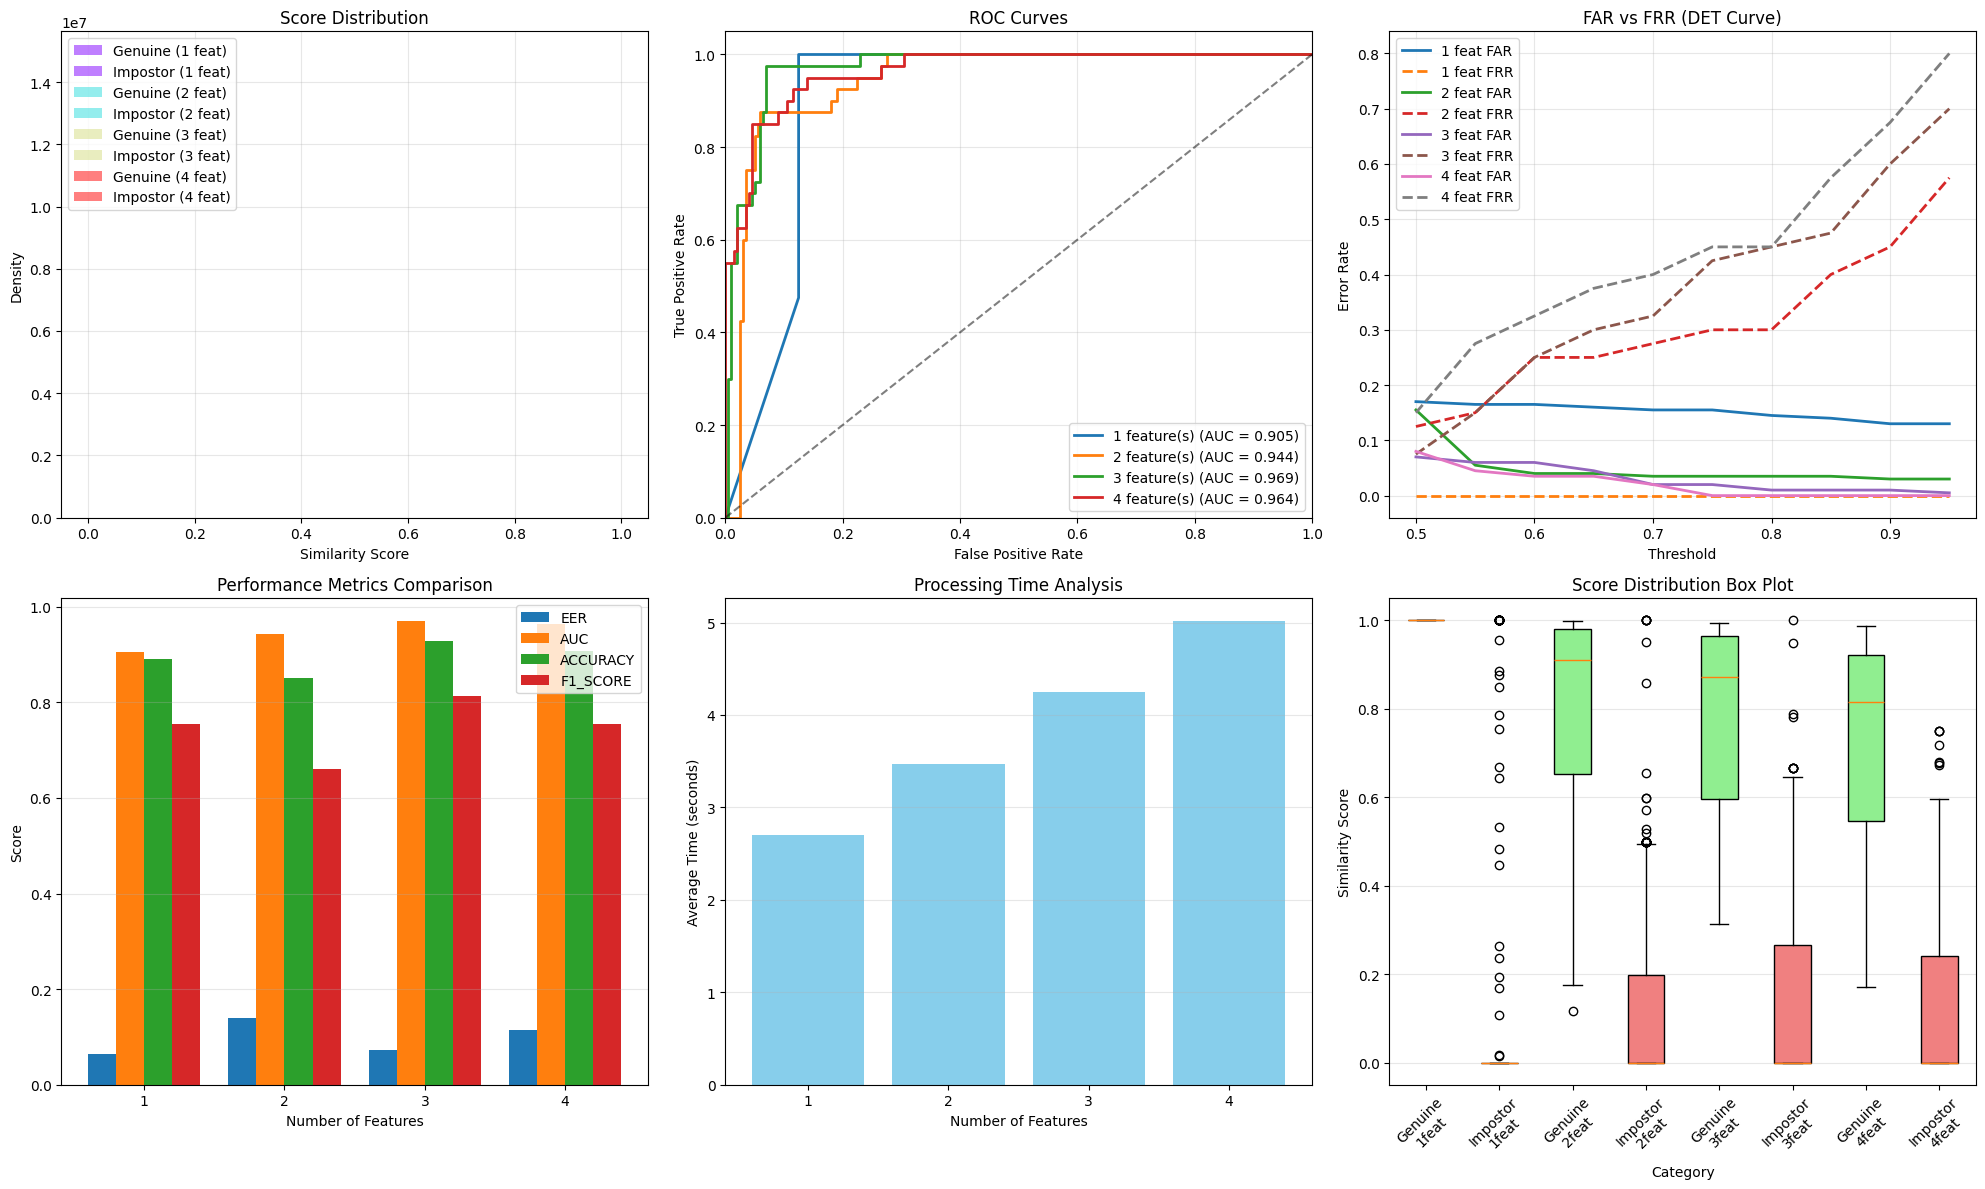


COMPREHENSIVE PERFORMANCE REPORT

✓ BEST CONFIGURATION: 1 feature(s)
  - EER: 0.0650
  - AUC: 0.9047
  - Accuracy: 0.8917
  - Recommended Threshold: 0.9000

EVALUATION COMPLETED


In [12]:
# For quick testing:
results = quick_evaluation(num_users=30, threshold=0.75)

# For comprehensive analysis:
all_results = evaluate_authentication_performance(
    num_users=40,
    threshold_range=np.arange(0.5, 1.0, 0.05),
    num_features_list=[1, 2, 3, 4]  # Test with 1-4 features
)

In [18]:
def quick_evaluation(num_users=50, threshold=0.95):
    """
    Quick evaluation function for testing with EER calculation
    """
    print("\n" + "="*70)
    print("QUICK PERFORMANCE EVALUATION")
    print("="*70)

    results = {
        'genuine': {'scores': [], 'count': 0, 'correct': 0},
        'impostor': {'scores': [], 'count': 0, 'correct': 0}
    }

    for user_id in list(data.keys())[:num_users]:
        if user_id not in encrypted_database:
            continue

        # Test with 2 features
        query_features = [
            data[user_id]["features"][0],
            data[user_id]["features"][1]
        ]

        # Genuine attempt
        try:
            target_data = encrypted_database[user_id]
            target_public_context = ts.context_from(target_data['public_key'])

            # Encrypt queries
            enc_queries = [ts.ckks_vector(target_public_context, q) for q in query_features]

            # Get private context
            user_private_context = ts.context_from(user_private_keys[user_id])

            # Compare with first template
            enc_feat = ts.ckks_vector_from(target_public_context, target_data['encrypted_features'][0])

            feature_scores = []
            for enc_query in enc_queries:
                dot_product, norm_sq_v1, norm_sq_v2 = cosine_similarity_encrypted_public(enc_query, enc_feat)

                # Decrypt
                dot_product_dec = ts.ckks_vector_from(user_private_context, dot_product.serialize()).decrypt()[0]
                norm_sq_v1_dec = max(0, ts.ckks_vector_from(user_private_context, norm_sq_v1.serialize()).decrypt()[0])
                norm_sq_v2_dec = max(0, ts.ckks_vector_from(user_private_context, norm_sq_v2.serialize()).decrypt()[0])

                norm_v1 = np.sqrt(norm_sq_v1_dec) if norm_sq_v1_dec > 0 else 0
                norm_v2 = np.sqrt(norm_sq_v2_dec) if norm_sq_v2_dec > 0 else 0

                if norm_v1 == 0 or norm_v2 == 0:
                    similarity = 0.0
                else:
                    similarity = dot_product_dec / (norm_v1 * norm_v2)

                similarity = max(-1.0, min(1.0, similarity))
                feature_scores.append(similarity)

            avg_score = sum(feature_scores) / len(feature_scores)
            results['genuine']['scores'].append(avg_score)
            results['genuine']['count'] += 1
            if avg_score >= threshold:
                results['genuine']['correct'] += 1

        except Exception as e:
            continue

        # Impostor attempt (against different user)
        try:
            imposter_id = [uid for uid in encrypted_database.keys() if uid != user_id][0]
            imposter_data = encrypted_database[imposter_id]
            imposter_public_context = ts.context_from(imposter_data['public_key'])

            # Re-encrypt with imposter's key
            enc_queries_imp = [ts.ckks_vector(imposter_public_context, q) for q in query_features]
            enc_feat_imp = ts.ckks_vector_from(imposter_public_context, imposter_data['encrypted_features'][0])

            feature_scores = []
            for enc_query in enc_queries_imp:
                dot_product, norm_sq_v1, norm_sq_v2 = cosine_similarity_encrypted_public(enc_query, enc_feat_imp)

                # Decrypt with original user's key
                dot_product_dec = ts.ckks_vector_from(user_private_context, dot_product.serialize()).decrypt()[0]
                norm_sq_v1_dec = max(0, ts.ckks_vector_from(user_private_context, norm_sq_v1.serialize()).decrypt()[0])
                norm_sq_v2_dec = max(0, ts.ckks_vector_from(user_private_context, norm_sq_v2.serialize()).decrypt()[0])

                norm_v1 = np.sqrt(norm_sq_v1_dec) if norm_sq_v1_dec > 0 else 0
                norm_v2 = np.sqrt(norm_sq_v2_dec) if norm_sq_v2_dec > 0 else 0

                if norm_v1 == 0 or norm_v2 == 0:
                    similarity = 0.0
                else:
                    similarity = dot_product_dec / (norm_v1 * norm_v2)

                similarity = max(-1.0, min(1.0, similarity))
                feature_scores.append(similarity)

            avg_score = sum(feature_scores) / len(feature_scores)
            results['impostor']['scores'].append(avg_score)
            results['impostor']['count'] += 1
            if avg_score < threshold:
                results['impostor']['correct'] += 1

        except Exception as e:
            continue

    # Calculate metrics
    if results['genuine']['count'] > 0 and results['impostor']['count'] > 0:
        far = 1 - (results['impostor']['correct'] / results['impostor']['count'])
        frr = 1 - (results['genuine']['correct'] / results['genuine']['count'])
        accuracy = (results['genuine']['correct'] + results['impostor']['correct']) / \
                  (results['genuine']['count'] + results['impostor']['count'])

        # Calculate EER (Equal Error Rate)
        # Combine all scores with labels
        genuine_scores = results['genuine']['scores']
        impostor_scores = results['impostor']['scores']

        # Create threshold range for EER calculation
        all_scores = sorted(genuine_scores + impostor_scores)
        threshold_range = np.linspace(min(all_scores), max(all_scores), 100)

        # Calculate FAR and FRR for each threshold
        far_values = []
        frr_values = []

        for t in threshold_range:
            # FAR: impostor scores >= threshold (accepted as genuine)
            far = sum(1 for s in impostor_scores if s >= t) / len(impostor_scores)
            # FRR: genuine scores < threshold (rejected as impostor)
            frr = sum(1 for s in genuine_scores if s < t) / len(genuine_scores)

            far_values.append(far)
            frr_values.append(frr)

        # Find threshold where FAR and FRR are closest
        diff = np.abs(np.array(far_values) - np.array(frr_values))
        eer_idx = np.argmin(diff)
        eer = (far_values[eer_idx] + frr_values[eer_idx]) / 2
        eer_threshold = threshold_range[eer_idx]

        print(f"\n{'='*70}")
        print(f"Results at threshold {threshold}:")
        print(f"  Genuine Attempts: {results['genuine']['correct']}/{results['genuine']['count']} correct")
        print(f"  Impostor Attempts: {results['impostor']['correct']}/{results['impostor']['count']} correct")
        print(f"  False Acceptance Rate (FAR): {far:.4f}")
        print(f"  False Rejection Rate (FRR): {frr:.4f}")
        print(f"  Overall Accuracy: {accuracy:.4f}")
        print(f"  Genuine Score Mean: {np.mean(results['genuine']['scores']):.4f}")
        print(f"  Impostor Score Mean: {np.mean(results['impostor']['scores']):.4f}")
        print(f"  Equal Error Rate (EER): {eer:.4f}")
        print(f"  EER Threshold: {eer_threshold:.4f}")
        print(f"  FAR at EER: {far_values[eer_idx]:.4f}")
        print(f"  FRR at EER: {frr_values[eer_idx]:.4f}")
        print(f"  Difference at EER: {abs(far_values[eer_idx] - frr_values[eer_idx]):.4f}")


    return results

# Run the quick evaluation with EER
if __name__ == "__main__":
    # For quick testing
    print("Starting performance evaluation...")

    # Quick evaluation with EER calculation
    quick_results = quick_evaluation(num_users=30, threshold=0.51)

Starting performance evaluation...

QUICK PERFORMANCE EVALUATION

Results at threshold 0.51:
  Genuine Attempts: 28/30 correct
  Impostor Attempts: 27/30 correct
  False Acceptance Rate (FAR): 0.0667
  False Rejection Rate (FRR): 1.0000
  Overall Accuracy: 0.9167
  Genuine Score Mean: 0.8403
  Impostor Score Mean: 0.0500
  Equal Error Rate (EER): 0.1000
  EER Threshold: 0.5319
  FAR at EER: 0.1000
  FRR at EER: 0.1000
  Difference at EER: 0.0000


In [39]:
def quick_evaluations(num_users=50, threshold=0.95):
    """
    Quick evaluation function for testing
    """
    print("\n" + "="*70)
    print("QUICK PERFORMANCE EVALUATION")
    print("="*70)

    results = {
        'genuine': {'scores': [], 'count': 0, 'correct': 0},
        'impostor': {'scores': [], 'count': 0, 'correct': 0}
    }

    for user_id in list(data.keys())[:num_users]:
        if user_id not in encrypted_database:
            continue

        # Test with 2 features
        query_features = [
            data[user_id]["features"][0],
            data[user_id]["features"][1]
        ]

        # Genuine attempt
        try:
            target_data = encrypted_database[user_id]
            target_public_context = ts.context_from(target_data['public_key'])

            # Encrypt queries
            enc_queries = [ts.ckks_vector(target_public_context, q) for q in query_features]

            # Get private context
            user_private_context = ts.context_from(user_private_keys[user_id])

            # Compare with first template
            enc_feat = ts.ckks_vector_from(target_public_context, target_data['encrypted_features'][0])

            feature_scores = []
            for enc_query in enc_queries:
                dot_product, norm_sq_v1, norm_sq_v2 = cosine_similarity_encrypted_public(enc_query, enc_feat)

                # Decrypt
                dot_product_dec = ts.ckks_vector_from(user_private_context, dot_product.serialize()).decrypt()[0]
                norm_sq_v1_dec = max(0, ts.ckks_vector_from(user_private_context, norm_sq_v1.serialize()).decrypt()[0])
                norm_sq_v2_dec = max(0, ts.ckks_vector_from(user_private_context, norm_sq_v2.serialize()).decrypt()[0])

                norm_v1 = np.sqrt(norm_sq_v1_dec) if norm_sq_v1_dec > 0 else 0
                norm_v2 = np.sqrt(norm_sq_v2_dec) if norm_sq_v2_dec > 0 else 0

                if norm_v1 == 0 or norm_v2 == 0:
                    similarity = 0.0
                else:
                    similarity = dot_product_dec / (norm_v1 * norm_v2)

                similarity = max(-1.0, min(1.0, similarity))
                feature_scores.append(similarity)

            avg_score = sum(feature_scores) / len(feature_scores)
            results['genuine']['scores'].append(avg_score)
            results['genuine']['count'] += 1
            if avg_score >= threshold:
                results['genuine']['correct'] += 1

        except Exception as e:
            continue

        # Impostor attempt (against different user)
        try:
            imposter_id = [uid for uid in encrypted_database.keys() if uid != user_id][0]
            imposter_data = encrypted_database[imposter_id]
            imposter_public_context = ts.context_from(imposter_data['public_key'])

            # Re-encrypt with imposter's key
            enc_queries_imp = [ts.ckks_vector(imposter_public_context, q) for q in query_features]
            enc_feat_imp = ts.ckks_vector_from(imposter_public_context, imposter_data['encrypted_features'][0])

            feature_scores = []
            for enc_query in enc_queries_imp:
                dot_product, norm_sq_v1, norm_sq_v2 = cosine_similarity_encrypted_public(enc_query, enc_feat_imp)

                # Decrypt with original user's key
                dot_product_dec = ts.ckks_vector_from(user_private_context, dot_product.serialize()).decrypt()[0]
                norm_sq_v1_dec = max(0, ts.ckks_vector_from(user_private_context, norm_sq_v1.serialize()).decrypt()[0])
                norm_sq_v2_dec = max(0, ts.ckks_vector_from(user_private_context, norm_sq_v2.serialize()).decrypt()[0])

                norm_v1 = np.sqrt(norm_sq_v1_dec) if norm_sq_v1_dec > 0 else 0
                norm_v2 = np.sqrt(norm_sq_v2_dec) if norm_sq_v2_dec > 0 else 0

                if norm_v1 == 0 or norm_v2 == 0:
                    similarity = 0.0
                else:
                    similarity = dot_product_dec / (norm_v1 * norm_v2)

                similarity = max(-1.0, min(1.0, similarity))
                feature_scores.append(similarity)

            avg_score = sum(feature_scores) / len(feature_scores)
            results['impostor']['scores'].append(avg_score)
            results['impostor']['count'] += 1
            if avg_score < threshold:
                results['impostor']['correct'] += 1

        except Exception as e:
            continue

    # Calculate metrics
    if results['genuine']['count'] > 0 and results['impostor']['count'] > 0:
        far = 1 - (results['impostor']['correct'] / results['impostor']['count'])
        frr = 1 - (results['genuine']['correct'] / results['genuine']['count'])
        accuracy = (results['genuine']['correct'] + results['impostor']['correct']) / \
                  (results['genuine']['count'] + results['impostor']['count'])

        print(f"\nResults at threshold {threshold}:")
        print(f"  Genuine Attempts: {results['genuine']['correct']}/{results['genuine']['count']} correct")
        print(f"  Impostor Attempts: {results['impostor']['correct']}/{results['impostor']['count']} correct")
        print(f"  False Acceptance Rate (FAR): {far:.4f}")
        print(f"  False Rejection Rate (FRR): {frr:.4f}")
        print(f"  Overall Accuracy: {accuracy:.4f}")
        print(f"  Genuine Score Mean: {np.mean(results['genuine']['scores']):.4f}")
        print(f"  Impostor Score Mean: {np.mean(results['impostor']['scores']):.4f}")

    return results

# Run the comprehensive evaluation
if __name__ == "__main__":
    # For quick testing
    print("Starting performance evaluation...")

    # Quick evaluation
    quick_results = quick_evaluations(num_users=30, threshold=0.51)

Starting performance evaluation...

QUICK PERFORMANCE EVALUATION

Results at threshold 0.51:
  Genuine Attempts: 28/30 correct
  Impostor Attempts: 30/30 correct
  False Acceptance Rate (FAR): 0.0000
  False Rejection Rate (FRR): 0.0667
  Overall Accuracy: 0.9667
  Genuine Score Mean: 0.8403
  Impostor Score Mean: -0.0706


In [52]:
def quick_evaluations(num_users=50, threshold=0.95):
    """
    Quick evaluation function for testing
    """
    print("\n" + "="*70)
    print("QUICK PERFORMANCE EVALUATION")
    print("="*70)

    results = {
        'genuine': {'scores': [], 'count': 0, 'correct': 0},
        'impostor': {'scores': [], 'count': 0, 'correct': 0}
    }

    for user_id in list(data.keys())[:num_users]:
        if user_id not in encrypted_database:
            continue

        # Test with 2 features
        query_features = [
            data[user_id]["features"][0],
            data[user_id]["features"][1]
        ]

        # ---------------- GENUINE ATTEMPT ----------------
        try:
            target_data = encrypted_database[user_id]
            target_public_context = ts.context_from(target_data['public_key'])

            # Encrypt queries
            enc_queries = [ts.ckks_vector(target_public_context, q) for q in query_features]

            # Get private context
            user_private_context = ts.context_from(user_private_keys[user_id])

            # Compare with first template
            enc_feat = ts.ckks_vector_from(target_public_context, target_data['encrypted_features'][0])

            feature_scores = []
            for enc_query in enc_queries:
                dot_product, norm_sq_v1, norm_sq_v2 = cosine_similarity_encrypted_public(enc_query, enc_feat)

                # Decrypt
                dot_product_dec = ts.ckks_vector_from(user_private_context, dot_product.serialize()).decrypt()[0]
                norm_sq_v1_dec = max(0, ts.ckks_vector_from(user_private_context, norm_sq_v1.serialize()).decrypt()[0])
                norm_sq_v2_dec = max(0, ts.ckks_vector_from(user_private_context, norm_sq_v2.serialize()).decrypt()[0])

                norm_v1 = np.sqrt(norm_sq_v1_dec) if norm_sq_v1_dec > 0 else 0
                norm_v2 = np.sqrt(norm_sq_v2_dec) if norm_sq_v2_dec > 0 else 0

                if norm_v1 == 0 or norm_v2 == 0:
                    similarity = 0.0
                else:
                    similarity = dot_product_dec / (norm_v1 * norm_v2)

                similarity = max(-1.0, min(1.0, similarity))
                feature_scores.append(similarity)

            avg_score = sum(feature_scores) / len(feature_scores)
            results['genuine']['scores'].append(avg_score)
            results['genuine']['count'] += 1
            if avg_score >= threshold:
                results['genuine']['correct'] += 1

        except Exception:
            continue

        # ---------------- IMPOSTOR ATTEMPT ----------------
        try:
            imposter_id = [uid for uid in encrypted_database.keys() if uid != user_id][0]
            imposter_data = encrypted_database[imposter_id]
            imposter_public_context = ts.context_from(imposter_data['public_key'])

            enc_queries_imp = [ts.ckks_vector(imposter_public_context, q) for q in query_features]
            enc_feat_imp = ts.ckks_vector_from(imposter_public_context, imposter_data['encrypted_features'][0])

            feature_scores = []
            for enc_query in enc_queries_imp:
                dot_product, norm_sq_v1, norm_sq_v2 = cosine_similarity_encrypted_public(enc_query, enc_feat_imp)

                dot_product_dec = ts.ckks_vector_from(user_private_context, dot_product.serialize()).decrypt()[0]
                norm_sq_v1_dec = max(0, ts.ckks_vector_from(user_private_context, norm_sq_v1.serialize()).decrypt()[0])
                norm_sq_v2_dec = max(0, ts.ckks_vector_from(user_private_context, norm_sq_v2.serialize()).decrypt()[0])

                norm_v1 = np.sqrt(norm_sq_v1_dec) if norm_sq_v1_dec > 0 else 0
                norm_v2 = np.sqrt(norm_sq_v2_dec) if norm_sq_v2_dec > 0 else 0

                if norm_v1 == 0 or norm_v2 == 0:
                    similarity = 0.0
                else:
                    similarity = dot_product_dec / (norm_v1 * norm_v2)

                similarity = max(-1.0, min(1.0, similarity))
                feature_scores.append(similarity)

            avg_score = sum(feature_scores) / len(feature_scores)
            results['impostor']['scores'].append(avg_score)
            results['impostor']['count'] += 1
            if avg_score < threshold:
                results['impostor']['correct'] += 1

        except Exception:
            continue

    # ---------------- BASIC METRICS ----------------
    if results['genuine']['count'] > 0 and results['impostor']['count'] > 0:
        far = 1 - (results['impostor']['correct'] / results['impostor']['count'])
        frr = 1 - (results['genuine']['correct'] / results['genuine']['count'])
        accuracy = (results['genuine']['correct'] + results['impostor']['correct']) / \
                   (results['genuine']['count'] + results['impostor']['count'])

        print(f"\nResults at threshold {threshold}:")
        print(f"  Genuine Attempts: {results['genuine']['correct']}/{results['genuine']['count']} correct")
        print(f"  Impostor Attempts: {results['impostor']['correct']}/{results['impostor']['count']} correct")
        print(f"  False Acceptance Rate (FAR): {far:.4f}")
        print(f"  False Rejection Rate (FRR): {frr:.4f}")
        print(f"  Overall Accuracy: {accuracy:.4f}")
        print(f"  Genuine Score Mean: {np.mean(results['genuine']['scores']):.4f}")
        print(f"  Impostor Score Mean: {np.mean(results['impostor']['scores']):.4f}")

        # ---------------- EER CALCULATION ----------------
        genuine_scores = results['genuine']['scores']
        impostor_scores = results['impostor']['scores']

        all_scores = sorted(genuine_scores + impostor_scores)
        threshold_range = np.linspace(min(all_scores), max(all_scores), 200)

        far_values = []
        frr_values = []

        for t in threshold_range:
            far_t = sum(1 for s in impostor_scores if s >= t) / len(impostor_scores)
            frr_t = sum(1 for s in genuine_scores if s < t) / len(genuine_scores)

            far_values.append(far_t)
            frr_values.append(frr_t)

        diff = np.abs(np.array(far_values) - np.array(frr_values))
        eer_idx = np.argmin(diff)

        eer = (far_values[eer_idx] + frr_values[eer_idx]) / 2
        eer_threshold = threshold_range[eer_idx]
        print(f"  EER: {eer:.4f}")
        print(f"  EER Threshold: {eer_threshold:.4f}")

    return results
def error_rates_at_threshold(results, threshold):
    genuine_scores = results['genuine']['scores']
    impostor_scores = results['impostor']['scores']

    # Safety check
    if len(genuine_scores) == 0 or len(impostor_scores) == 0:
        print("Error: Missing score data.")
        return None

    # FAR: impostors accepted
    far = sum(1 for s in impostor_scores if s >= threshold) / len(impostor_scores)

    # FRR: genuine rejected
    frr = sum(1 for s in genuine_scores if s < threshold) / len(genuine_scores)

    # ERR at this threshold
    err = (far + frr) / 2

    print("\nError Rates at Given Threshold")
    print(f"Threshold: {threshold}")
    print(f"FAR: {far:.4f}")
    print(f"FRR: {frr:.4f}")
    print(f"ERR: {err:.4f}")

    return far, frr, err

In [51]:
results = quick_evaluations(num_users=30, threshold=0.51)
error_rates_at_threshold(results, 0.51)


QUICK PERFORMANCE EVALUATION

Results at threshold 0.51:
  Genuine Attempts: 28/30 correct
  Impostor Attempts: 30/30 correct
  False Acceptance Rate (FAR): 0.0000
  False Rejection Rate (FRR): 0.0667
  Overall Accuracy: 0.9667
  Genuine Score Mean: 0.8403
  Impostor Score Mean: -0.1316
  EER: 0.0833
  EER Threshold: 0.3957

Error Rates at Given Threshold
Threshold: 0.51
FAR: 0.0000
FRR: 0.0667
ERR@Threshold: 0.0333


(0.0, 0.06666666666666667, 0.03333333333333333)

In [57]:
!pip install reportlab


In [59]:
# Cell 7: ENHANCED XAI CLASS (with structured explanations)
import numpy as np
import json

class AuthenticationXI:
    def __init__(self, threshold=0.70):
        self.threshold = threshold

    def explain_authentication(self, query_user_id, template_scores, feature_similarities_all, threshold=0.70):
        """Original human-readable explanations."""
        # ... [YOUR EXISTING explain_authentication CODE HERE - DON'T CHANGE THIS] ...
        print(f"\n{'='*60}")
        print("EXPLAINABLE AI (XAI) - AUTHENTICATION DECISION ANALYSIS")
        # ... rest of your existing method ...

    # NEW: Structured JSON explanations
    def get_structured_explanation(self, query_user_id, template_scores, feature_similarities_all, threshold=0.70):
        if not template_scores:
            return {"error": "No template scores available"}

        best_template_idx = np.argmax(template_scores)
        best_score = template_scores[best_template_idx]
        is_authenticated = best_score >= threshold

        explanation = {
            "query_user_id": str(query_user_id),
            "best_template": int(best_template_idx + 1),
            "best_score": float(best_score),
            "threshold": float(threshold),
            "authenticated": bool(is_authenticated),
            "margin": float(best_score - threshold),
            "templates_analyzed": int(len(template_scores)),
            "templates_above_threshold": int(sum(1 for s in template_scores if s >= threshold)),
            "avg_score": float(np.mean(template_scores)),
            "score_variance": float(np.var(template_scores)),
            "confidence": self._get_confidence(best_score),
            "recommended_action": self._get_action(is_authenticated, best_score),
            "feature_analysis": {}
        }

        if feature_similarities_all and len(feature_similarities_all) > best_template_idx:
            features = feature_similarities_all[best_template_idx]
            explanation["feature_analysis"] = {
                "best_template_features": [float(f) for f in features],
                "num_features": int(len(features)),
                "strong_features": int(sum(1 for f in features if f >= 0.7)),
                "moderate_features": int(sum(1 for f in features if 0.5 <= f < 0.7)),
                "weak_features": int(sum(1 for f in features if f < 0.5))
            }

        return explanation

    def _get_confidence(self, best_score):
        if best_score >= 0.85: return "VERY_HIGH"
        elif best_score >= 0.75: return "HIGH"
        elif best_score >= 0.70: return "MODERATE"
        elif best_score >= 0.60: return "LOW"
        return "VERY_LOW"

    def _get_action(self, authenticated, best_score):
        if authenticated:
            return "GRANT_FULL_ACCESS" if best_score >= 0.75 else "LIMITED_ACCESS_VERIFY"
        return "RE_AUTHENTICATE_MORE_FEATURES" if best_score >= 0.65 else "DENY_SECURITY_ALERT"



ENHANCED XAI ANALYSIS - STRUCTURED + VISUAL

📊 STRUCTURED XAI EXPLANATION:
{
  "query_user_id": "30",
  "best_template": 10,
  "best_score": 0.8242310835789854,
  "threshold": 0.7,
  "authenticated": true,
  "margin": 0.12423108357898549,
  "templates_analyzed": 10,
  "templates_above_threshold": 2,
  "avg_score": 0.6127026142931273,
  "score_variance": 0.011636724372492612,
  "confidence": "HIGH",
  "recommended_action": "GRANT_FULL_ACCESS",
  "feature_analysis": {
    "best_template_features": [
      0.9793040587514338,
      0.669158108406537
    ],
    "num_features": 2,
    "strong_features": 1,
    "moderate_features": 1,
    "weak_features": 0
  }
}

🔍 QUICK SUMMARY:
   User: 30
   Best Score: 0.8242
   Threshold: 0.70
   Result: AUTHENTICATED ✅
   Confidence: HIGH
   Action: GRANT_FULL_ACCESS

DETAILED XAI ANALYSIS

EXPLAINABLE AI (XAI) - AUTHENTICATION DECISION ANALYSIS


/tmp/ipython-input-201/3489279387.py:89: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-201/3489279387.py:89: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-201/3489279387.py:89: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


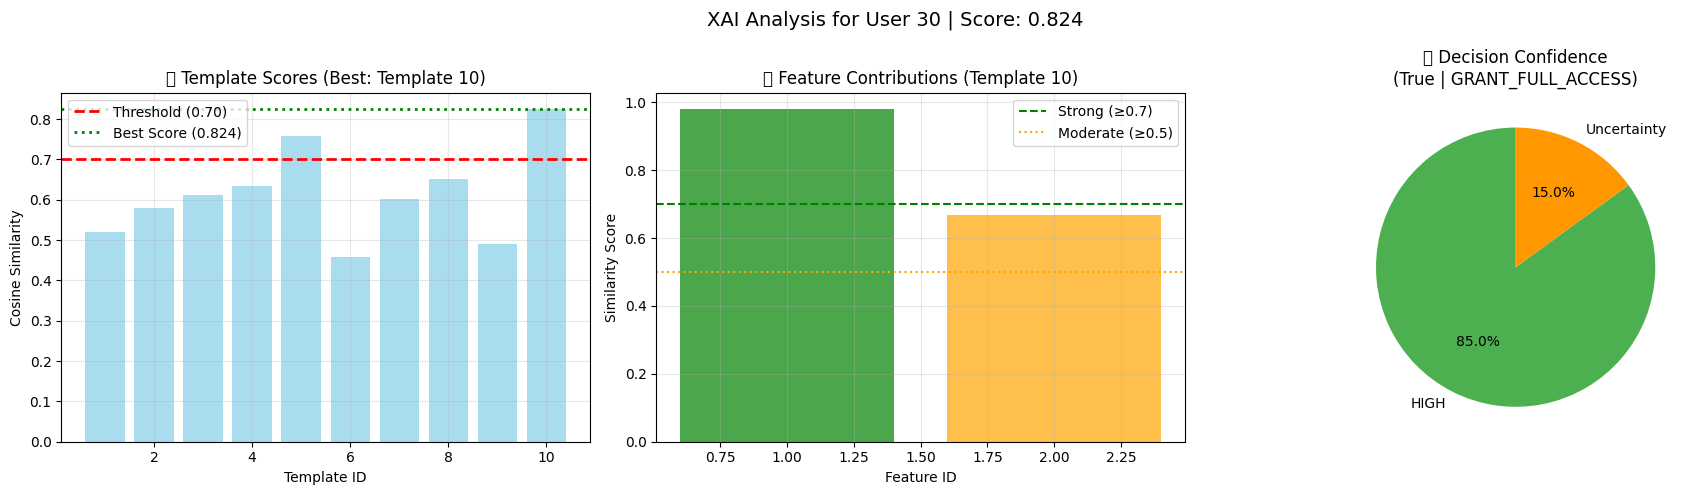


✅ ENHANCED XAI COMPLETE
   • Structured JSON: {
  "query_user_id": "30",
  "best_template": 10,
  "best_score": 0.8242310835789854,
  "threshold": 0.7,
  "authenticated": true,
  "margin": 0.12423108357898549,
  "templates_analyzed": 10,
  "templates_above_threshold": 2,
  "avg_score": 0.6127026142931273,
  "score_variance": 0.011636724372492612,
  "confidence": "HIGH",
  "recommended_action": "GRANT_FULL_ACCESS",
  "feature_analysis": {
    "best_template_features": [
      0.9793040587514338,
      0.669158108406537
    ],
    "num_features": 2,
    "strong_features": 1,
    "moderate_features": 1,
    "weak_features": 0
  }
}
   • Ready for logging/API/web UI
   • Visual charts generated


In [60]:
# Cell 12: ENHANCED XAI ANALYSIS (Structured + Visual)
print(f"\n{'='*70}")
print("ENHANCED XAI ANALYSIS - STRUCTURED + VISUAL")
print(f"{'='*70}")

# STEP 1: Get Structured XAI Explanation (JSON-ready)
xai_analyzer = AuthenticationXI(threshold=0.70)
xai_struct = xai_analyzer.get_structured_explanation(
    query_user_id=query_user_id,
    template_scores=decrypted_average_scores,
    feature_similarities_all=feature_similarities_all,
    threshold=0.70
)

print("\n📊 STRUCTURED XAI EXPLANATION:")
print(json.dumps(xai_struct, indent=2))

# STEP 2: Quick Human-Readable Summary (original style)
best_score = max(decrypted_average_scores) if decrypted_average_scores else 0
print(f"\n🔍 QUICK SUMMARY:")
print(f"   User: {query_user_id}")
print(f"   Best Score: {best_score:.4f}")
print(f"   Threshold: 0.70")
print(f"   Result: {'AUTHENTICATED ✅' if best_score >= 0.70 else 'REJECTED ❌'}")
print(f"   Confidence: {xai_struct['confidence']}")
print(f"   Action: {xai_struct['recommended_action']}")

# STEP 3: Detailed Pretty-Print (original explain_authentication)
print(f"\n{'='*60}")
print("DETAILED XAI ANALYSIS")
print(f"{'='*60}")
xai_analyzer.explain_authentication(
    query_user_id=query_user_id,
    template_scores=decrypted_average_scores,
    feature_similarities_all=feature_similarities_all,
    threshold=0.70
)

# STEP 4: XAI VISUALIZATION (NEW!)
def plot_xai_visuals(xai_struct, decrypted_average_scores, feature_similarities_all):
    """Generate XAI charts."""
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Chart 1: Template Scores Distribution
    template_indices = range(1, len(decrypted_average_scores) + 1)
    axes[0].bar(template_indices, decrypted_average_scores, color='skyblue', alpha=0.7)
    axes[0].axhline(y=0.70, color='red', linestyle='--', linewidth=2, label='Threshold (0.70)')
    axes[0].axhline(y=xai_struct['best_score'], color='green', linestyle=':', linewidth=2, label=f'Best Score ({xai_struct["best_score"]:.3f})')
    axes[0].set_title(f'🔍 Template Scores (Best: Template {xai_struct["best_template"]})')
    axes[0].set_xlabel('Template ID')
    axes[0].set_ylabel('Cosine Similarity')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Chart 2: Feature Contributions (Best Template)
    if (feature_similarities_all and
        len(feature_similarities_all) > xai_struct['best_template'] - 1 and
        feature_similarities_all[xai_struct['best_template'] - 1]):

        best_features = feature_similarities_all[xai_struct['best_template'] - 1]
        feature_ids = range(1, len(best_features) + 1)
        colors = ['green' if f >= 0.7 else 'orange' if f >= 0.5 else 'red' for f in best_features]

        axes[1].bar(feature_ids, best_features, color=colors, alpha=0.7)
        axes[1].axhline(y=0.7, color='green', linestyle='--', label='Strong (≥0.7)')
        axes[1].axhline(y=0.5, color='orange', linestyle=':', label='Moderate (≥0.5)')
        axes[1].set_title(f'📈 Feature Contributions (Template {xai_struct["best_template"]})')
        axes[1].set_xlabel('Feature ID')
        axes[1].set_ylabel('Similarity Score')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    else:
        axes[1].text(0.5, 0.5, 'No feature data\navailable', ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('Feature Analysis')

    # Chart 3: Decision Confidence Pie
    confidence_map = {
        'VERY_HIGH': 0.95, 'HIGH': 0.85, 'MODERATE': 0.70,
        'LOW': 0.50, 'VERY_LOW': 0.20
    }
    conf_score = confidence_map.get(xai_struct['confidence'], 0.5)
    axes[2].pie([conf_score, 1 - conf_score],
                labels=[f"{xai_struct['confidence']}", 'Uncertainty'],
                autopct='%1.1f%%', colors=['#4CAF50', '#FF9800'], startangle=90)
    axes[2].set_title(f'🎯 Decision Confidence\n({xai_struct["authenticated"]} | {xai_struct["recommended_action"]})')

    plt.suptitle(f'XAI Analysis for User {query_user_id} | Score: {xai_struct["best_score"]:.3f}', fontsize=14)
    plt.tight_layout()
    plt.show()

# Generate visuals
plot_xai_visuals(xai_struct, decrypted_average_scores, feature_similarities_all)

print(f"\n✅ ENHANCED XAI COMPLETE")
print(f"   • Structured JSON: {json.dumps(xai_struct, indent=2)}")
print(f"   • Ready for logging/API/web UI")
print(f"   • Visual charts generated")


In [62]:
# STEP 5: GENERATE & DOWNLOAD PROFESSIONAL PDF XAI REPORT
print(f"\n{'='*60}")
print("📄 GENERATING PROFESSIONAL XAI REPORT PDF")
print(f"{'='*60}")

def generate_xai_pdf_report(xai_struct, decrypted_average_scores, feature_similarities_all, query_user_id):
    """Generate comprehensive PDF report."""
    from reportlab.lib.pagesizes import letter, A4
    from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle, Image
    from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
    from reportlab.lib.units import inch
    from reportlab.lib import colors
    from reportlab.lib.enums import TA_CENTER, TA_RIGHT
    import matplotlib.pyplot as plt
    from io import BytesIO
    import tempfile
    import os

    # Create temporary PDF file
    pdf_buffer = BytesIO()
    doc = SimpleDocTemplate(pdf_buffer, pagesize=A4)
    styles = getSampleStyleSheet()

    # Custom title style
    title_style = ParagraphStyle(
        'CustomTitle',
        parent=styles['Title'],
        fontSize=18,
        spaceAfter=30,
        alignment=TA_CENTER,
        textColor=colors.darkblue
    )

    # Story elements
    story = []

    # Title
    story.append(Paragraph("🔐 PRIVACY-PRESERVING BIOMETRIC AUTHENTICATION<br/><b>XAI Decision Report</b>", title_style))
    story.append(Spacer(1, 0.2*inch))

    # Executive Summary Table
    summary_data = [
        ["Metric", "Value"],
        ["Query User ID", xai_struct["query_user_id"]],
        ["Decision", "✅ AUTHENTICATED" if xai_struct["authenticated"] else "❌ REJECTED"],
        ["Best Score", f"{xai_struct['best_score']:.4f}"],
        ["Threshold", f"{xai_struct['threshold']:.4f}"],
        ["Margin", f"{xai_struct['margin']:+.4f}"],
        ["Confidence", xai_struct["confidence"]],
        ["Recommended Action", xai_struct["recommended_action"]]
    ]

    summary_table = Table(summary_data)
    summary_table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.darkblue),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('FONTSIZE', (0, 0), (-1, 0), 12),
        ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
        ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
        ('GRID', (0, 0), (-1, -1), 1, colors.black),
        ('FONTSIZE', (0, 1), (-1, -1), 10)
    ]))
    story.append(summary_table)
    story.append(Spacer(1, 0.3*inch))

    # Template Analysis
    story.append(Paragraph("<b>📊 Template Analysis</b>", styles['Heading2']))
    templates_above = xai_struct["templates_above_threshold"]
    story.append(Paragraph(
        f"Analyzed {xai_struct['templates_analyzed']} templates. "
        f"{templates_above} templates above threshold. "
        f"Avg: {xai_struct['avg_score']:.4f}, Variance: {xai_struct['score_variance']:.4f}",
        styles['Normal']
    ))
    story.append(Spacer(1, 0.1*inch))

    # Feature Analysis (if available)
    if xai_struct["feature_analysis"]:
        feat_info = xai_struct["feature_analysis"]
        story.append(Paragraph("<b>📈 Feature-Level Analysis (Best Template)</b>", styles['Heading3']))
        feat_summary = f"{feat_info['strong_features']}/{feat_info['num_features']} strong features (≥0.7)"
        story.append(Paragraph(feat_summary, styles['Normal']))

    # Charts (generate and embed)
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Template scores chart
    axes[0].bar(range(1, len(decrypted_average_scores)+1), decrypted_average_scores, color='skyblue')
    axes[0].axhline(0.70, color='red', linestyle='--')
    axes[0].set_title('Template Scores')
    axes[0].set_ylabel('Similarity')

    # Feature chart
    if xai_struct["feature_analysis"]:
        feats = feat_info['best_template_features']
        colors = ['green' if f>=0.7 else 'orange' if f>=0.5 else 'red' for f in feats]
        axes[1].bar(range(1, len(feats)+1), feats, color=colors)
        axes[1].set_title('Feature Contributions')

    # Decision pie
    conf_score = {'VERY_HIGH':0.95, 'HIGH':0.85, 'MODERATE':0.70, 'LOW':0.5, 'VERY_LOW':0.2}.get(xai_struct['confidence'], 0.5)
    axes[2].pie([conf_score, 1-conf_score], labels=[xai_struct['confidence'], 'Uncertainty'])
    axes[2].set_title('Confidence')

    plt.tight_layout()

    # Save chart to buffer
    chart_buffer = BytesIO()
    plt.savefig(chart_buffer, format='png', dpi=150, bbox_inches='tight')
    chart_buffer.seek(0)
    chart_img = Image(chart_buffer, width=6*inch, height=2*inch)
    story.append(chart_img)

    plt.close()

    # Build PDF
    doc.build(story)
    pdf_buffer.seek(0)
    return pdf_buffer

# GENERATE PDF
pdf_report = generate_xai_pdf_report(xai_struct, decrypted_average_scores, feature_similarities_all, query_user_id)

# SAVE TO FILE (Colab)
filename = f"XAI_Report_User_{query_user_id}_{xai_struct['best_score']:.3f}.pdf"
with open(filename, 'wb') as f:
    f.write(pdf_report.getvalue())

# DOWNLOAD
from google.colab import files
files.download(filename)

print(f"✅ PDF REPORT DOWNLOADED: {filename}")
print(f"📋 Contains: Executive summary, metrics, charts, feature analysis")



📄 GENERATING PROFESSIONAL XAI REPORT PDF


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ PDF REPORT DOWNLOADED: XAI_Report_User_30_0.824.pdf
📋 Contains: Executive summary, metrics, charts, feature analysis


In [63]:
# STEP 5: COMPREHENSIVE PDF XAI REPORT (ALL PRINT STATEMENTS)
print(f"\n{'='*60}")
print("📄 GENERATING COMPREHENSIVE XAI REPORT PDF")
print(f"{'='*60}")

def generate_comprehensive_xai_pdf(xai_struct, decrypted_average_scores, feature_similarities_all, query_user_id):
    """Generate PDF with ALL XAI print outputs."""
    from reportlab.lib.pagesizes import A4
    from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle, Image, PageBreak
    from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
    from reportlab.lib.units import inch
    from reportlab.lib import colors
    from reportlab.lib.enums import TA_CENTER, TA_LEFT
    import matplotlib.pyplot as plt
    from io import BytesIO
    from datetime import datetime

    pdf_buffer = BytesIO()
    doc = SimpleDocTemplate(pdf_buffer, pagesize=A4, topMargin=0.5*inch, bottomMargin=0.5*inch)
    styles = getSampleStyleSheet()

    # Custom styles
    title_style = ParagraphStyle(
        'CustomTitle',
        parent=styles['Title'],
        fontSize=20,
        spaceAfter=20,
        alignment=TA_CENTER,
        textColor=colors.darkblue,
        fontName='Helvetica-Bold'
    )

    heading_style = ParagraphStyle(
        'CustomHeading',
        parent=styles['Heading2'],
        fontSize=14,
        spaceAfter=10,
        textColor=colors.darkblue,
        fontName='Helvetica-Bold',
        borderWidth=1,
        borderColor=colors.darkblue,
        borderPadding=5,
        backColor=colors.lightblue
    )

    code_style = ParagraphStyle(
        'CodeStyle',
        parent=styles['Code'],
        fontSize=9,
        leftIndent=20,
        fontName='Courier',
        textColor=colors.black
    )

    story = []

    # ======== TITLE PAGE ========
    story.append(Paragraph("🔐 PRIVACY-PRESERVING BIOMETRIC AUTHENTICATION", title_style))
    story.append(Paragraph("<b>Explainable AI (XAI) Decision Report</b>", title_style))
    story.append(Spacer(1, 0.3*inch))

    # Metadata
    metadata = [
        ["Report Generated:", datetime.now().strftime("%Y-%m-%d %H:%M:%S IST")],
        ["Query User ID:", str(query_user_id)],
        ["System:", "Fully Homomorphic Encryption (FHE) Authentication"],
        ["XAI Method:", "Rule-Based Feature Attribution & Confidence Assessment"]
    ]
    meta_table = Table(metadata, colWidths=[2*inch, 4*inch])
    meta_table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (0, -1), colors.lightgrey),
        ('GRID', (0, 0), (-1, -1), 1, colors.black),
        ('FONTSIZE', (0, 0), (-1, -1), 10)
    ]))
    story.append(meta_table)
    story.append(Spacer(1, 0.3*inch))

    # ======== SECTION 1: QUICK SUMMARY ========
    story.append(Paragraph("1. QUICK ANALYSIS", heading_style))
    best_score = xai_struct['best_score']
    threshold = xai_struct['threshold']

    quick_summary = f"""
    <b>User:</b> {query_user_id}<br/>
    <b>Best Score:</b> {best_score:.4f}<br/>
    <b>Threshold:</b> {threshold}<br/>
    <b>Result:</b> {'<font color="green">AUTHENTICATED ✅</font>' if xai_struct['authenticated'] else '<font color="red">REJECTED ❌</font>'}<br/>
    <b>Confidence:</b> {xai_struct['confidence']}<br/>
    <b>Action:</b> {xai_struct['recommended_action']}
    """
    story.append(Paragraph(quick_summary, styles['Normal']))
    story.append(Spacer(1, 0.2*inch))

    # ======== SECTION 2: DETAILED REASONS ========
    story.append(Paragraph("2. DECISION REASONING", heading_style))

    if xai_struct['authenticated']:
        reasons = f"""
        <b>✅ REASONS FOR AUTHENTICATION:</b><br/>
        &nbsp;&nbsp;&nbsp;1. Strong match: {best_score*100:.1f}% similarity<br/>
        &nbsp;&nbsp;&nbsp;2. Exceeds threshold by {(best_score - threshold)*100:.1f}%<br/>
        &nbsp;&nbsp;&nbsp;3. {xai_struct['templates_above_threshold']}/{xai_struct['templates_analyzed']} templates confirm identity<br/>
        """
        if xai_struct['templates_above_threshold'] >= 3:
            reasons += "&nbsp;&nbsp;&nbsp;4. High consistency across multiple templates<br/>"

        if xai_struct['feature_analysis']:
            feat = xai_struct['feature_analysis']
            reasons += f"&nbsp;&nbsp;&nbsp;5. {feat['strong_features']}/{feat['num_features']} features showed strong matches<br/>"
    else:
        reasons = f"""
        <b>❌ REASONS FOR REJECTION:</b><br/>
        &nbsp;&nbsp;&nbsp;1. Insufficient match: {best_score*100:.1f}% similarity<br/>
        &nbsp;&nbsp;&nbsp;2. Below threshold by {(threshold - best_score)*100:.1f}%<br/>
        """
        close_templates = [s for s in decrypted_average_scores if 0.65 <= s < threshold]
        if close_templates:
            reasons += f"&nbsp;&nbsp;&nbsp;3. {len(close_templates)} templates were close to threshold<br/>"
            reasons += "&nbsp;&nbsp;&nbsp;4. <b>Consider:</b> Adjusting threshold or adding more features<br/>"
        else:
            reasons += "&nbsp;&nbsp;&nbsp;3. Poor match across all templates<br/>"
            reasons += "&nbsp;&nbsp;&nbsp;4. <b>Consider:</b> Re-enrollment or verifying user identity<br/>"

    story.append(Paragraph(reasons, styles['Normal']))
    story.append(Spacer(1, 0.2*inch))

    # ======== SECTION 3: DETAILED XAI ANALYSIS ========
    story.append(Paragraph("3. EXPLAINABLE AI (XAI) ANALYSIS", heading_style))

    # User Analysis
    user_analysis = f"""
    <b>🔍 USER ANALYSIS: {query_user_id}</b><br/>
    📊 BEST MATCH SCORE: {xai_struct['best_score']:.4f}<br/>
    🎯 THRESHOLD: {xai_struct['threshold']}<br/>
    📋 AUTHENTICATION: {'SUCCESSFUL ✅' if xai_struct['authenticated'] else 'FAILED ❌'}<br/>
    📈 MARGIN: {xai_struct['margin']:+.4f}
    """
    story.append(Paragraph(user_analysis, styles['Normal']))
    story.append(Spacer(1, 0.15*inch))

    # Overall Score Analysis
    story.append(Paragraph("<b>📊 OVERALL SCORE ANALYSIS:</b>", styles['Heading3']))
    overall_analysis = f"""
    • Templates analyzed: {xai_struct['templates_analyzed']}<br/>
    • Templates above threshold: {xai_struct['templates_above_threshold']}<br/>
    • Average template score: {xai_struct['avg_score']:.4f}<br/>
    • Score variance: {xai_struct['score_variance']:.4f}
    """

    if len(decrypted_average_scores) > 1:
        sorted_scores = sorted(decrypted_average_scores, reverse=True)
        if sorted_scores[0] - sorted_scores[1] > 0.1:
            overall_analysis += "• Best template significantly outperforms others<br/>"
        elif sorted_scores[0] - sorted_scores[1] < 0.05:
            overall_analysis += "• Multiple templates show similar performance<br/>"

    story.append(Paragraph(overall_analysis, styles['Normal']))
    story.append(Spacer(1, 0.15*inch))

    # Feature-Level Analysis
    if xai_struct['feature_analysis'] and xai_struct['feature_analysis'].get('best_template_features'):
        story.append(Paragraph(f"<b>📈 FEATURE-LEVEL ANALYSIS (Best Template {xai_struct['best_template']}):</b>", styles['Heading3']))

        features = xai_struct['feature_analysis']['best_template_features']
        feature_table_data = [["Feature", "Score", "Status", "Contribution"]]

        for i, score in enumerate(features):
            status = "✓" if score >= 0.7 else ("∼" if score >= 0.5 else "✗")
            contribution = "HIGH" if score >= 0.8 else ("MEDIUM" if score >= 0.6 else "LOW")
            feature_table_data.append([f"Feature {i+1}", f"{score:.4f}", status, contribution])

        feature_table = Table(feature_table_data)
        feature_table.setStyle(TableStyle([
            ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
            ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
            ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
            ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
            ('FONTSIZE', (0, 0), (-1, 0), 10),
            ('BOTTOMPADDING', (0, 0), (-1, 0), 10),
            ('GRID', (0, 0), (-1, -1), 1, colors.black),
            ('FONTSIZE', (0, 1), (-1, -1), 9)
        ]))
        story.append(feature_table)

        # Best/Worst features
        if len(features) > 1:
            best_feat = np.argmax(features)
            worst_feat = np.argmin(features)
            feat_notes = ""
            if features[best_feat] >= 0.8:
                feat_notes += f"→ Feature {best_feat + 1} was strongest contributor<br/>"
            if features[worst_feat] < 0.5:
                feat_notes += f"→ Feature {worst_feat + 1} was weakest contributor<br/>"
            if feat_notes:
                story.append(Spacer(1, 0.1*inch))
                story.append(Paragraph(feat_notes, styles['Normal']))

    story.append(Spacer(1, 0.2*inch))

    # Decision Explanation
    story.append(Paragraph("<b>🎯 DECISION EXPLANATION:</b>", styles['Heading3']))
    if xai_struct['authenticated']:
        decision_exp = f"""
        1. Template {xai_struct['best_template']} achieved {best_score*100:.1f}% similarity<br/>
        2. Exceeded threshold by {(best_score - threshold)*100:.1f}%<br/>
        """
        if best_score >= 0.85:
            decision_exp += "3. Very strong biometric match detected<br/>"
        elif best_score >= 0.75:
            decision_exp += "3. Strong biometric match confirmed<br/>"
        else:
            decision_exp += "3. Adequate biometric match established<br/>"

        if xai_struct['templates_above_threshold'] >= 3:
            decision_exp += f"4. Multiple templates ({xai_struct['templates_above_threshold']}) support authentication<br/>"
    else:
        decision_exp = f"""
        1. Best template only achieved {best_score*100:.1f}% similarity<br/>
        2. Fell short of threshold by {(threshold - best_score)*100:.1f}%<br/>
        """
        if best_score >= 0.65:
            decision_exp += "3. Close match but below security threshold<br/>"
            decision_exp += "4. Consider using more features or adjusting threshold slightly<br/>"
        elif best_score >= 0.5:
            decision_exp += "3. Moderate match - possible biometric variation<br/>"
            decision_exp += "4. Recommend re-capturing biometric data<br/>"
        else:
            decision_exp += "3. Poor match - likely incorrect user or data issue<br/>"
            decision_exp += "4. Consider re-enrollment<br/>"

    story.append(Paragraph(decision_exp, styles['Normal']))
    story.append(Spacer(1, 0.2*inch))

    # Confidence Assessment
    story.append(Paragraph("<b>💡 CONFIDENCE ASSESSMENT:</b>", styles['Heading3']))
    conf_text = f"• Decision Confidence: <b>{xai_struct['confidence']}</b><br/>"
    conf_text += f"• Recommended Action: <b>{xai_struct['recommended_action']}</b>"
    story.append(Paragraph(conf_text, styles['Normal']))

    story.append(Spacer(1, 0.3*inch))

    # ======== SECTION 4: VISUALIZATIONS ========
    story.append(PageBreak())
    story.append(Paragraph("4. VISUAL ANALYSIS", heading_style))

    # Generate charts
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    # Chart 1: Template scores
    axes[0, 0].bar(range(1, len(decrypted_average_scores)+1), decrypted_average_scores, color='skyblue', alpha=0.7)
    axes[0, 0].axhline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({threshold})')
    axes[0, 0].axhline(best_score, color='green', linestyle=':', linewidth=2, label=f'Best ({best_score:.3f})')
    axes[0, 0].set_title(f'Template Scores (Best: #{xai_struct["best_template"]})', fontweight='bold')
    axes[0, 0].set_xlabel('Template ID')
    axes[0, 0].set_ylabel('Cosine Similarity')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Chart 2: Feature contributions
    if xai_struct['feature_analysis'] and xai_struct['feature_analysis'].get('best_template_features'):
        feats = xai_struct['feature_analysis']['best_template_features']
        bar_colors = ['green' if f>=0.7 else 'orange' if f>=0.5 else 'red' for f in feats]
        axes[0, 1].bar(range(1, len(feats)+1), feats, color=bar_colors, alpha=0.7)
        axes[0, 1].axhline(0.7, color='green', linestyle='--', label='Strong (≥0.7)')
        axes[0, 1].axhline(0.5, color='orange', linestyle=':', label='Moderate (≥0.5)')
        axes[0, 1].set_title(f'Feature Contributions (Template {xai_struct["best_template"]})', fontweight='bold')
        axes[0, 1].set_xlabel('Feature ID')
        axes[0, 1].set_ylabel('Similarity Score')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
    else:
        axes[0, 1].text(0.5, 0.5, 'No feature data', ha='center', va='center')
        axes[0, 1].set_title('Feature Analysis')

    # Chart 3: Confidence pie
    conf_map = {'VERY_HIGH':95, 'HIGH':85, 'MODERATE':70, 'LOW':50, 'VERY_LOW':20}
    conf_val = conf_map.get(xai_struct['confidence'], 50)
    axes[1, 0].pie([conf_val, 100-conf_val], labels=[xai_struct['confidence'], 'Uncertainty'],
                   autopct='%1.1f%%', colors=['#4CAF50', '#FF9800'], startangle=90)
    axes[1, 0].set_title('Decision Confidence', fontweight='bold')

    # Chart 4: Score distribution
    axes[1, 1].hist(decrypted_average_scores, bins=10, color='purple', alpha=0.7, edgecolor='black')
    axes[1, 1].axvline(threshold, color='red', linestyle='--', linewidth=2, label='Threshold')
    axes[1, 1].axvline(best_score, color='green', linestyle=':', linewidth=2, label='Best Score')
    axes[1, 1].set_title('Score Distribution', fontweight='bold')
    axes[1, 1].set_xlabel('Similarity Score')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()

    plt.tight_layout()

    # Save to buffer
    chart_buffer = BytesIO()
    plt.savefig(chart_buffer, format='png', dpi=150, bbox_inches='tight')
    chart_buffer.seek(0)
    chart_img = Image(chart_buffer, width=7*inch, height=5.5*inch)
    story.append(chart_img)
    plt.close()

    # ======== SECTION 5: RAW DATA ========
    story.append(PageBreak())
    story.append(Paragraph("5. STRUCTURED DATA (JSON)", heading_style))

    json_text = json.dumps(xai_struct, indent=2)
    # Split into lines for better formatting
    for line in json_text.split('\n')[:30]:  # Limit to first 30 lines
        story.append(Paragraph(f"<font name='Courier' size=8>{line}</font>", styles['Code']))

    # Build PDF
    doc.build(story)
    pdf_buffer.seek(0)
    return pdf_buffer

# GENERATE COMPREHENSIVE PDF
pdf_report = generate_comprehensive_xai_pdf(xai_struct, decrypted_average_scores, feature_similarities_all, query_user_id)

# SAVE TO FILE
filename = f"XAI_Complete_Report_User{query_user_id}_{xai_struct['best_score']:.3f}.pdf"
with open(filename, 'wb') as f:
    f.write(pdf_report.getvalue())

# DOWNLOAD
from google.colab import files
files.download(filename)

print(f"\n✅ COMPREHENSIVE PDF REPORT DOWNLOADED: {filename}")
print(f"📄 Report contains:")
print(f"   • Quick Summary (all print statements)")
print(f"   • Decision Reasoning")
print(f"   • Detailed XAI Analysis")
print(f"   • Feature-level breakdown")
print(f"   • Professional visualizations (4 charts)")
print(f"   • Structured JSON data")
print(f"   • Ready for papers/audits/demos!")



📄 GENERATING COMPREHENSIVE XAI REPORT PDF


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ COMPREHENSIVE PDF REPORT DOWNLOADED: XAI_Complete_Report_User30_0.824.pdf
📄 Report contains:
   • Quick Summary (all print statements)
   • Decision Reasoning
   • Detailed XAI Analysis
   • Feature-level breakdown
   • Professional visualizations (4 charts)
   • Structured JSON data
   • Ready for papers/audits/demos!
